In [9]:
# I need to tell python where my libaraies
# are. You should probably remove it
import sys
sys.path.append('C:\Anaconda3\Lib\site-packages')

import numpy as np
from sklearn.neighbors.kde import KernelDensity

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

#import seaborn as sns
#sns.set_style('white')
#sns.set_context('poster')

# Variational Monte Carlo (VMC) program

We'll use a similar Markov chain Monte Carlo (MCMC) code as post 3 but adapt it to calculate a quantity $E$. The main addition is the ability to propagate $N$ particles at once, simulating multiple particles in a box. This still requires only one Markov chain per box and we'll use many boxes (i.e., many walkers).

To understand the usefullness of VMC we need to think about the variational principle from quantum mechanics, but before getting to that lets simply pose the problem:

Given a probability distribution $P(\mathbf{R})$, where $\mathbf{R}$ is the particle configuration vector, calculate the average energy $E$. In practive the energy depends on many different properties of the particles (e.g., position, spin, charge, etc...). As well, the kintetic term depends on the Laplacian (second derivative) of the wave function $\Psi_V(\mathbf{R})$.  We're going to cheat to avoid dealing with that beast i.e., we'll use *some made-up function for the kinetic energy* $T$. We have


$$E(\mathbf{R}) = T(\mathbf{R}) + V(\mathbf{R}), ...(1)$$

where $V(\mathbf{R})$ is the cumulative "potential energy" of the particles. It will reflect how particles "want" to be closer together. For each pair of particles, let's use a shifted Gaussian function like this:

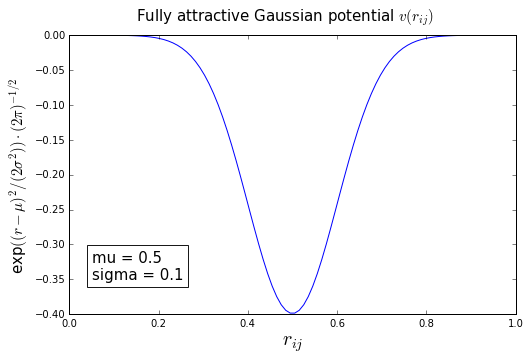

In [10]:
from scipy import stats

mu = 0.5
sig = 0.1
y = lambda r: -stats.norm.pdf((r-mu)/(sig))

fig = plt.figure(figsize=(8, 5))
plt.suptitle('Fully attractive Gaussian potential $v(r_{ij})$',
             fontsize=15)

box = dict(boxstyle='square', facecolor='white', alpha=0.9)
plt.text(0.05, -0.35, 'mu = {} \nsigma = {}'.format(mu, sig),
         fontsize=15, bbox=box)

xx = np.linspace(0, 1, 100)
yy = [y(x) for x in xx]

plt.subplot(111)
plt.plot(xx, yy)
plt.ylabel('exp$((r-\mu)^2/(2\sigma^2))\cdot(2\pi)^{-1/2}$', fontsize=15)
plt.xlabel('$r_{ij}$', fontsize=20)

# plt.savefig('figures/attractive_gausssian_potential.png', bbox_inches='tight', dpi=144)

Lets split the system into two groups of size $N/2$ that interact only with eachother. We then have

$$ V(\mathbf{R}) = \sum_{i<j'}^{N} v(r_{i, j'}) $$

where $i$ is one species and $j'$ is the other. Let use $N=4$ such that we have

$$ V(\mathbf{R}) =  v(r_{1, 1'}) + v(r_{1, 2'}) + v(r_{2, 2'}). $$ 

The "kinetic" term $T(\mathbf{R})$ will be far less realistic than the potential term $V(\mathbf{R})$ (which itself contains an ad hoc two-body potential $v(\mathbf{r})$). Lets use this **made-up function**:

$$ T(\mathbf{R}) = \sum_i^{N/2} |\,x_i \cdot y_i\,| \sum_{j'}^{N/2} |\,x_{j'} \cdot y_{j'}\,| $$

It could be interpreted as the particles having more kinetic energy (i.e., larger $T$) depending on how far they are from the center of the box. This doesn't make sense physically of course.

Our energy-like function $E$ will change based on the configurations of the particles. We'll calculate it using each sample we take as the program runs and plot the results as a function of the attempted step number $N_{step}$. We should see $E$ stabalize once our walkers, starting from random configurations, have equilibrated.

For quantum mechanical particles, the probability distribution (of their location) is related to the wave function of the system. For now lets take the many-body wave function $\Psi_V(\mathbf{R})$ to be an addition of single-particle wave functions $\psi_1(\mathbf{r})$ and $\psi_2(\mathbf{r})$:

$$ \Psi_V(\mathbf{R}) = \sum_{i,j'} \Big[\psi_1(\mathbf{r}_i)+\psi_2(\mathbf{r}_i)\Big] $$

Lets take $\psi_1(\mathbf{r})$ to be a positive Gaussian and $\psi_2(\mathbf{r})$ to be a negative Gaussian.

In [11]:
def psi(x, y):
    ''' The addition of two 2D Gaussians. '''
    g1 = lambda x, y: mlab.bivariate_normal(x, y, 0.2, 0.2, -0.25, -0.25, 0)
    g2 = lambda x, y: -mlab.bivariate_normal(x, y, 0.2, 0.2, 0.25, 0.25, 0)
    f_lam = lambda x, y: g1(x, y) + g2(x, y)
    f = f_lam(x, y)
    
#     # Setting anything outside the box equal to zero
#     f_edit = f.ravel()
#     for i, xy in enumerate(zip(np.array([[x]]).ravel(), np.array([[y]]).ravel())):
#         if abs(xy[0]) > 1 or abs(xy[1]) > 1:
#             f_edit[i] = 0.0
#     f = np.reshape(f_edit, f.shape)

    return f

In order to keep the particles confined in a box of side length 2 centered at $r = (0,0)$, the many-body wave function $\Psi_V$ is set to 0 if $x_i>1$ or $y_i>1$ for any of the particles [1].

[1] - Usually particles are forced to stay inside the box using periodic boundary conditions, where e.g. if the particle were to leave the left side of the box it would immediately re-appear on the right side.

### Plots of wave functions and probability densitites
#### Single-particle wave function $\psi(\mathbf{r}) = \psi_1(\mathbf{r}) + \psi_2(\mathbf{r})$

<class 'numpy.ndarray'>
[[-1.   -1.   -1.   ..., -1.   -1.   -1.  ]
 [-0.99 -0.99 -0.99 ..., -0.99 -0.99 -0.99]
 [-0.98 -0.98 -0.98 ..., -0.98 -0.98 -0.98]
 ..., 
 [ 0.97  0.97  0.97 ...,  0.97  0.97  0.97]
 [ 0.98  0.98  0.98 ...,  0.98  0.98  0.98]
 [ 0.99  0.99  0.99 ...,  0.99  0.99  0.99]]
<class 'numpy.ndarray'>
(200, 200)


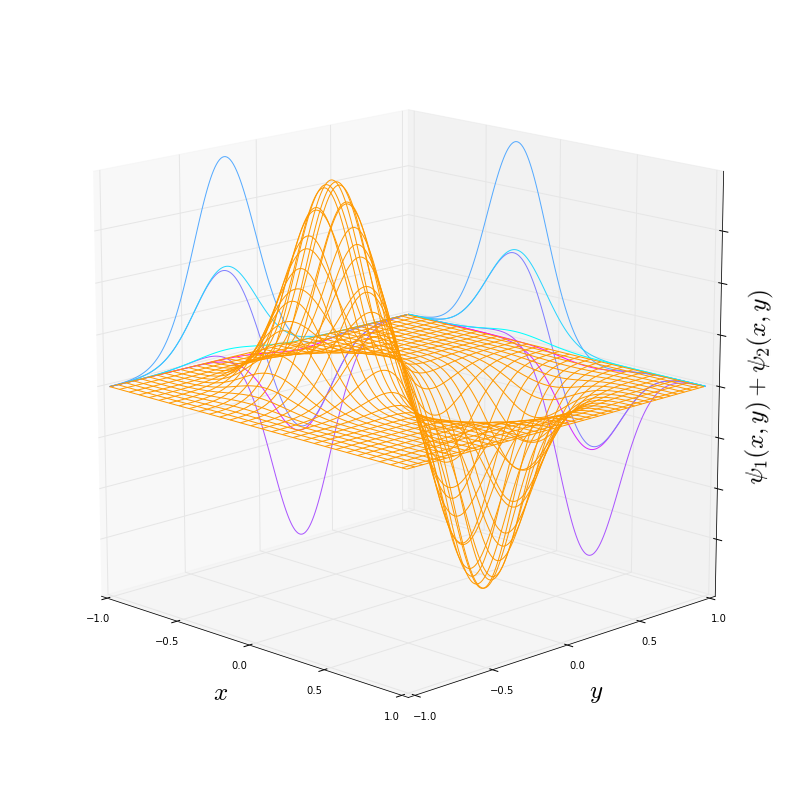

In [68]:
fig = plt.figure(figsize=(14,14))
ax = fig.gca(projection='3d')
#ax = fig.add_subplot(111, projection='3d')

x1, x2 = -1, 1
y1, y2 = -1, 1

# set up a meshgrid - like labeling (x,y) coordinates
# for each vertex on a piece of graph paper
dx = 0.01
x = np.arange(x1, x2, dx)
y = np.arange(y1, y2, dx)
X, Y = np.meshgrid(x, y)
print(type(Y))
print(Y)

# define Z as the value of the probability 
# distribution q at each 'vertex'
Z = psi(X, Y)
print(type(Z))
print(Z.shape)

# plot
ax.plot_wireframe(X,Y,Z, rstride=5, cstride=7,
                  color='#ff9900', alpha=1)
# ax.scatter(samples[:, 0], samples[:, 1], color='b', s=0.2)

# make it pretty (as found in Axes3D.contour documentation)
#cset = ax.contour(X, Y, Z, zdir='z', offset=-100, cmap=cm.coolwarm)
cset = ax.contour(X, Y, Z, zdir='y', offset=y2, cmap=cm.cool)
cset = ax.contour(X, Y, Z, zdir='x', offset=x1, cmap=cm.cool)

# plot contours of the density
#levels = np.linspace(0, znodes.max(), 25)
#nodal_surface = ax.contourf(nodes.T[0], nodes.T[1], znodes, levels=levels, cmap=plt.cm.Reds)

# define the limits
ax.set_xlabel('$x$', labelpad=15, fontsize=25)
ax.set_xlim(x1, x2)
ax.set_ylabel('$y$', labelpad=15, fontsize=25)
ax.set_ylim(y1, y2)
ax.set_zlabel('$\psi_1(x,y) + \psi_2(x,y)$', fontsize=25)
ax.set_zticklabels([])
#ax.set_zlim(0, 0.06)

ax.view_init(elev=15, azim=-45)

# plt.savefig('figures/single_particle_wave_function.png', bbox_inches='tight', dpi=144)

plt.show()

#### Single-particle probability distribution $\psi^2(\mathbf{r})$

<class 'numpy.ndarray'>
(200, 200)


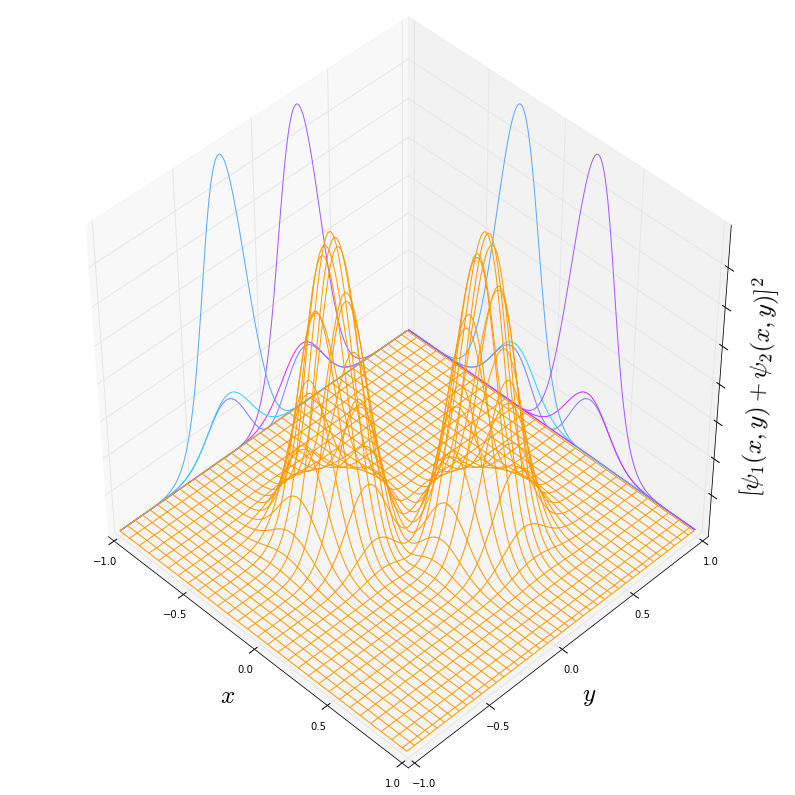

In [70]:
fig = plt.figure(figsize=(14,14))
ax = fig.gca(projection='3d')
#ax = fig.add_subplot(111, projection='3d')

x1, x2 = -1, 1
y1, y2 = -1, 1

# set up a meshgrid - like labeling (x,y) coordinates
# for each vertex on a piece of graph paper
dx = 0.01
x = np.arange(x1, x2, dx)
y = np.arange(y1, y2, dx)
X, Y = np.meshgrid(x, y)

# define Z as the value of the probability 
# distribution q at each 'vertex'
# Z becomes a 3D Numpy array
Z = psi(X, Y)
Z = np.square(Z)
print(type(Z))
print(Z.shape)

# plot
ax.plot_wireframe(X,Y,Z, rstride=5, cstride=7,
                  color='#ff9900', alpha=1)
# ax.scatter(samples[:, 0], samples[:, 1], color='b', s=0.2)

# make it pretty (as found in Axes3D.contour documentation)
#cset = ax.contour(X, Y, Z, zdir='z', offset=-100, cmap=cm.coolwarm)
cset = ax.contour(X, Y, Z, zdir='y', offset=y2, cmap=cm.cool)
cset = ax.contour(X, Y, Z, zdir='x', offset=x1, cmap=cm.cool)

# define the limits
ax.set_xlabel('$x$', labelpad=15, fontsize=25)
ax.set_xlim(x1, x2)
ax.set_ylabel('$y$', labelpad=15, fontsize=25)
ax.set_ylim(y1, y2)
ax.set_zlabel('$[\psi_1(x,y) + \psi_2(x,y)]^2$', fontsize=25)
ax.set_zticklabels([])
#ax.set_zlim(0, 0.06)

ax.view_init(elev=45, azim=-45)

# plt.savefig('figures/single_particle_wave_function_squared.png', bbox_inches='tight', dpi=144)

plt.show()

#### Plot the many-particle wave function $\Psi_V(\mathbf{R})$?
We would require a higher dimensional space for this because the configuration vector e.g., $\mathbf{R}=(\mathbf{r_1}, \mathbf{r_2}, \mathbf{r_3}, \mathbf{r_4})$ depends on the coordinates of 4 particles. We would need to include an axis for not just "$x$ and $y$" as done above, but for $x_1$, $x_2$, $x_3$, $x_4$, $y_1$, $y_2$, $y_3$, and $y_4$.

Notice how the wave function $\psi(\mathbf{r})$ has positive and negative regions?

The area where $\Psi_V(\mathbf{R})$ crosses in between the two (i.e. where $\Psi_V(\mathbf{R}) = 0$) is called the nodal surface. In this case, due to the symmetry of the two Gaussians,  the nodal surface is an infinite straight line passing through r = (x, y) = (1, -1) and r = (-1, 1) i.e., the diagonal in between the distributions.

From elementary quantum mechanics, the wave function $\Psi_V$ is realted to the probability density $P$ by

$$ P(\mathbf{R}) = |\Psi_V^2(\mathbf{R})| ... (2) $$

and this is what is sampled in VMC [1].

[1] - For Eq. 2 relating the probability distribution to the wave function, the absolute value is required for complex wave functions to ensure that $P(\mathbf{R})$ is always positive. We don't go into anything like this here.

In summary:

- initialize walkers with random starting sites
- run MCMC code to sample $P$ and calculate $E$ for each sample
- plot $E$ vs $N_{steps}$

However, before we concern ourselves with $E$, let's concentrate on sampling $\Psi_V$.

### VMC sampling

In [61]:
def psi_1(x, y):
    ''' A single-particle wave function. '''
    g1 = lambda x, y: mlab.bivariate_normal(x, y, 0.2, 0.2, -0.25, -0.25, 0)
    return g1(x, y)

def psi_2(x, y):
    ''' A single-particle wave function. '''
    g2 = lambda x, y: -mlab.bivariate_normal(x, y, 0.2, 0.2, 0.25, 0.25, 0)
    return g2(x, y)

def prob_density(R, N):
    ''' The square of the many body wave function
        Psi_V(R). '''

    # e.g. for N=2:
    # psi_v = psi_1(r_1) + psi_2(r_1) + psi_1(r_1') + psi_2(r_1')
    psi_v = sum([psi_1(R[n][0], R[n][1]) for n in range(N)]) + \
            sum([psi_2(R[n][0], R[n][1]) for n in range(N)])
        
    # Setting anything outside the box equal to zero
    # This will keep particles inside
    for coordinate in R.ravel():
        if abs(coordinate) > 1:
            psi_v = 0
    
    return np.float64(psi_v**2)

def Metroplis_algorithm_walkers(N, Nsteps, m, walkers, dr):
    ''' A Markov chain is constructed, using the
    Metropolis algorithm, that is comprised of
    samples of our probability density: psi(x,y).
    
    N - number of particles per box,
        must be an even number
    Nsteps - number of random moves to try
    m - will return a samples when i%m == 0
        in the loop over Nsteps,
        make sure Nsteps/m = integer
    walkers - number of unique Markov chains
              i.e., number of boxes
    dr - average size of moves (if uniform),
         controls the acceptance ratio '''
    
    # We'll want to return the average
    # acceptance ratio
    a_total = 0
    
    # Sample locations will be stored in a list
    samples = []
    
    # Get the starting configuration
    # and sample probability distribution
    # We'll start at a randomly
    # selected position for each walker
    r_prime = np.array(
              [[np.random.uniform(-1, 1, size=2) for n in range(N)]
               for w in range(walkers)])
    p_prime = np.array([prob_density(r_prime[w], N) for w in range(walkers)])
    
    # Initialize lists
    r = np.zeros(shape=r_prime.shape)
    p = np.zeros(shape=p_prime.shape)
    
    for i in range(Nsteps):
        for w in range(walkers):
            # Propose a random move: r'-> r
            r[w] = r_prime[w] + np.reshape(np.random.normal(loc=0, scale=dr,
                                                            size=len(r[w].ravel())),
                                           r[w].shape)
            # The probability distribution for each
            # walker is a float value found by taking a
            # sum of single-particle wave functions
            p[w] = prob_density(r[w], N)
        
            # Calculate the acceptance ratio
            # for the proposed move
            a = min(1, p[w]/p_prime[w])
            # Update the total
            a_total += a
            
            # Check for acceptance
            p_prime[w], r_prime[w] = check_move(p_prime[w], p[w],
                                                r_prime[w], r[w])
            
            if i%m == 0:
                # Must use np.copy for this to work properly
                samples.append(np.copy(r_prime[w]))
                
    return np.array(samples), a_total/Nsteps/walkers*100.0

    
def check_move(p_prime, p, r_prime, r):
    ''' The move will be accepted or rejected
        based on the ratio of p/p_prime and a
        random number. '''
    
    if p/p_prime >= 1:
        # accept the move
        return p, r
   
    else:
        rand = np.random.uniform(0, 1)
        if p/p_prime + rand >= 1:
            # accept the move
            return p, r
        else:
            # reject the move
            return p_prime, r_prime

In [64]:
Nparticles, Nsteps, m, walkers, dr = 4, 40, 10, 100, 0.1
samples, acceptance = Metroplis_algorithm_walkers(Nparticles, Nsteps, m, walkers, dr)
sample_stack = np.vstack((samples.T[0].ravel(), samples.T[1].ravel())).T

print('Acceptance ratio: {}%'.format(acceptance))
print('Shape of samples: {}'.format(samples.shape))
print('Shape of sample stack: {}'.format(sample_stack.shape))
print('x max/min:', max(sample_stack.T[0]), min(sample_stack.T[0]))
print('y max/min:', max(sample_stack.T[1]), min(sample_stack.T[1]))
samples

Acceptance ratio: 49.08801729183634%
Shape of samples: (400, 4, 2)
Shape of sample stack: (1600, 2)
x max/min: 0.999211031868 -0.999547907791
y max/min: 0.999955991362 -0.999189917179


array([[[-0.39480161, -0.10986284],
        [ 0.74687671,  0.33533877],
        [ 0.29214749,  0.73136898],
        [-0.02939671,  0.59682141]],

       [[ 0.82588973,  0.87426995],
        [ 0.82162905, -0.11331874],
        [-0.95345559, -0.8695142 ],
        [ 0.6089684 , -0.00405731]],

       [[ 0.90604996, -0.48295679],
        [-0.89914494, -0.5440683 ],
        [-0.45965548,  0.29493939],
        [-0.0531486 ,  0.70550098]],

       ..., 
       [[-0.86260665,  0.07644027],
        [ 0.42468811,  0.15310175],
        [ 0.39939584,  0.44893731],
        [-0.91736379, -0.30412649]],

       [[-0.38978475, -0.57899647],
        [ 0.36687011, -0.54329819],
        [ 0.87724582,  0.99848573],
        [-0.7807371 ,  0.33915839]],

       [[ 0.05863792,  0.51868002],
        [-0.69908067, -0.32609404],
        [ 0.2227826 ,  0.96266206],
        [ 0.31739044,  0.73841068]]])

### Runing the VMC script and plotting the results

Let's use $N=4$ and sample the square of the 4-particle wave function
$$ \Psi_V(\mathbf{R}) = \sum_i^{N/2=2} \psi_1(\mathbf{r}_i) + \psi_2(\mathbf{r}_i) + \sum_{j'}^{N/2=2} \psi_1(\mathbf{r}_{j'}) + \psi_2(\mathbf{r}_{j'})\\
= \psi_1(\mathbf{r}_1)+\psi_2(\mathbf{r}_1)+
\psi_1(\mathbf{r}_2)+\psi_2(\mathbf{r}_2)+\\
\psi_1(\mathbf{r}_{1'})+\psi_2(\mathbf{r}_{1'})+
\psi_1(\mathbf{r}_{2'})+\psi_2(\mathbf{r}_{2'}). $$
We'll plot "snapshots" of the walkers as the system evolves.

In [15]:
Nparticles, Nsteps, m, walkers, dr = 4, 40, 10, 1000, 0.1
samples, acceptance = Metroplis_algorithm_walkers(Nparticles, Nsteps, m, walkers, dr)
sample_stack = np.vstack((samples.T[0].ravel(), samples.T[1].ravel())).T

print('Acceptance ratio: {}%'.format(acceptance))
print('Shape of samples: {}'.format(samples.shape))
print('Shape of sample stack: {}'.format(sample_stack.shape))
print('x max/min:', max(sample_stack.T[0]), min(sample_stack.T[0]))
print('y max/min:', max(sample_stack.T[1]), min(sample_stack.T[1]))
samples

Acceptance ratio: 49.24417481586034%
Shape of samples: (4000, 4, 2)
Shape of sample stack: (16000, 2)
x max/min: 0.999939947822 -0.999696366224
y max/min: 0.999693767624 -0.999842404363


array([[[ 0.79350968, -0.88414982],
        [ 0.57597278, -0.43841468],
        [ 0.27071111,  0.90253792],
        [-0.38695198, -0.52674747]],

       [[-0.54038576,  0.41941131],
        [-0.66563361,  0.52286862],
        [-0.06851654,  0.28854698],
        [ 0.49254874, -0.90592816]],

       [[-0.25034249, -0.62460251],
        [-0.75391654,  0.08286812],
        [-0.22486169,  0.12417692],
        [ 0.19409284, -0.46518236]],

       ..., 
       [[-0.26465746, -0.31838941],
        [-0.29249959,  0.31662016],
        [-0.74166153,  0.17793631],
        [ 0.61654826, -0.99781824]],

       [[ 0.13141775,  0.20882829],
        [ 0.34527917, -0.43797866],
        [ 0.36948463,  0.49982396],
        [ 0.32972735, -0.73240581]],

       [[ 0.82944755,  0.76742212],
        [-0.90028319, -0.58070849],
        [-0.48456178,  0.00413206],
        [-0.65165821, -0.76962811]]])

We took 4000 samples with an average acceptance ratio of 49.24%
Taking one sample (containing 4 particles) every 10 steps


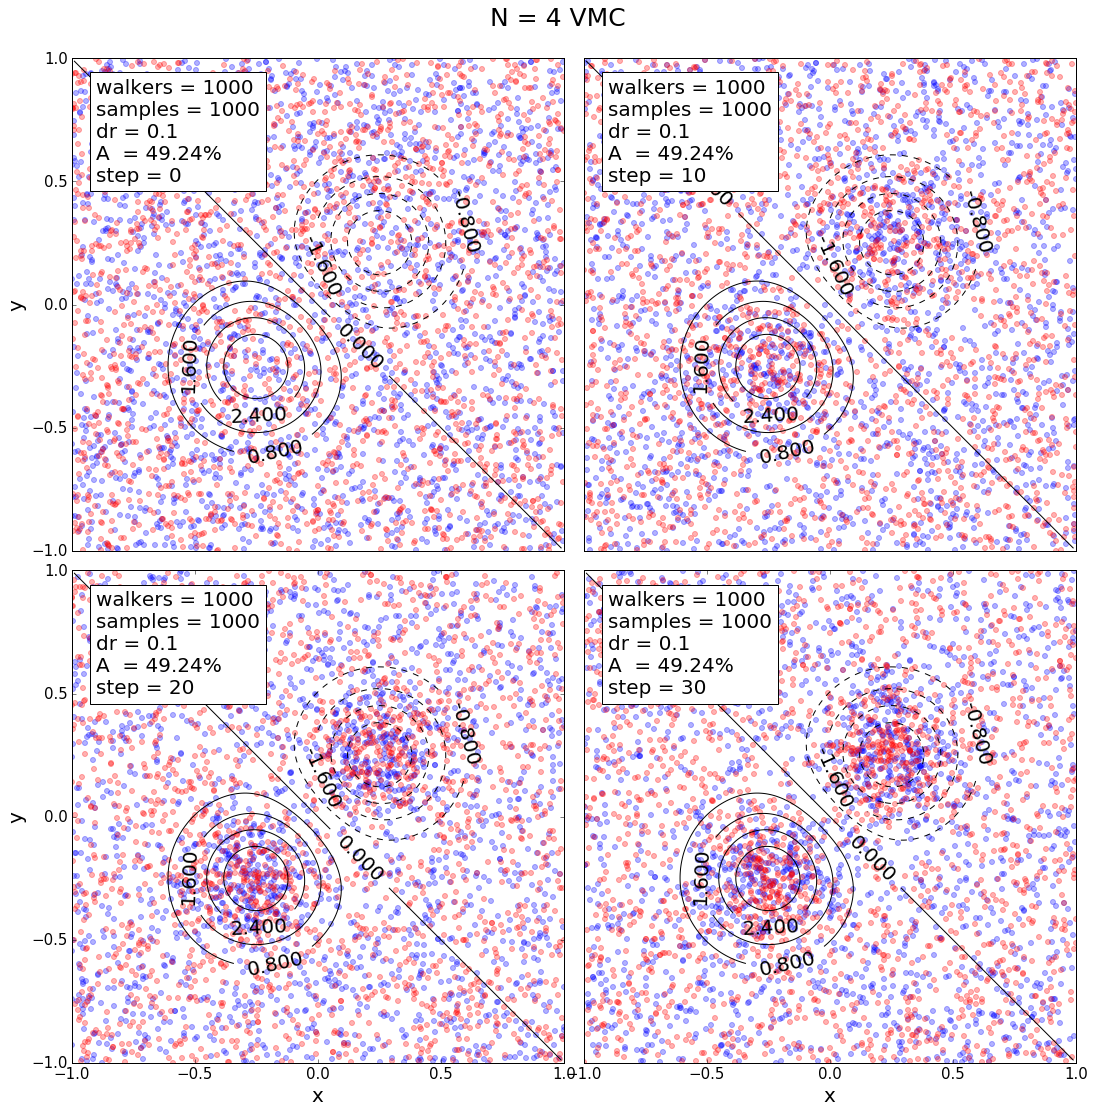

In [16]:
def plot_samples(samples, psi, limits=[]):
    ''' Plot the results of our Monte Carlo
        sampling along with the underlying
        probability distribution psi. Samples
        must be a numpy array in vstack format
        e.g. [[0.5, 0.3], [0.3, -0.3], ...]
        where the first half are species i
        and the second half are species j'. '''
    
    # set up a meshgrid
    dx = 0.01
    pad = 5
    if limits:
        xlow, xhigh = limits[0], limits[1]
        ylow, yhigh = limits[2], limits[3]
    else:
        xlow = np.min(samples)-pad 
        xhigh = np.max(samples)+pad
        ylow = np.min(samples)-pad
        yhigh = np.max(samples)+pad

    x = np.arange(xlow, xhigh, dx)
    y = np.arange(ylow, yhigh, dx)
    X, Y = np.meshgrid(x, y)

    # define Z as the value of the probability 
    # distribution psi at each 'vertex'
    # Z becomes a 2D Numpy array
    Z = psi(X, Y)
    
    # must be feeding in numpy arrays below
    # plot species i as blue points
    plt.scatter(samples[:int(len(samples)/2), 0],
                samples[:int(len(samples)/2), 1],
                alpha=0.3, s=25, color='blue')
    # plot species j' as blue points
    plt.scatter(samples[int(len(samples)/2):, 0],
                samples[int(len(samples)/2):, 1],
                alpha=0.3, s=25, color='red')
    CS = plt.contour(X, Y, Z, 10, colors='k')
    plt.clabel(CS, inline=1, fontsize=20)
    
    plt.xlim(xlow, xhigh)
    plt.ylim(ylow, yhigh)
    plt.xlabel('x', fontsize=20)
    plt.ylabel('y', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)


print('We took {0:d} samples with an average acceptance ratio of {1:.2f}%'
      .format(int(len(sample_stack)/Nparticles), acceptance))

box = dict(boxstyle='square', facecolor='white', alpha=1.0)

fig = plt.figure(figsize=(18,18))

# Making a 4 panel figure where the walkers are equilibrating over time
# will have to split samples into 4 sets
quads = np.array([samples[0:int(len(samples)/4)], samples[int(len(samples)/4):int(len(samples)/2)], 
                 samples[int(len(samples)/2):int(len(samples)*3/4)], samples[int(len(samples)*3/4):]])
quad_stack = [np.vstack((quads[i].T[0].ravel(), quads[i].T[1].ravel())).T
              for i in range(4)]
print('Taking one sample (containing', Nparticles, 'particles) every', m, 'steps')
for i in range(4):
    plt.subplot(2,2,i+1)
    plot_samples(quad_stack[i], psi, [-1, 1, -1, 1])
    plt.text(-0.9, 0.5, 'walkers = {0:d}\nsamples = {1:d}\ndr = {2:.1f}\nA  = {3:.2f}%\nstep = {4:d}'
                        .format(walkers, int(len(quad_stack[i])/Nparticles), dr, acceptance, int(i*len(quad_stack[0])/Nparticles*m/walkers)),
             fontsize=20, bbox=box, zorder=10)
    # Remove some x, y tick labels
    if i==0 or i==1:
        plt.xticks([])
        plt.xlabel('')
    if i==1 or i==3:
        plt.yticks([])
        plt.ylabel('')
    
    
plt.subplots_adjust(wspace=0.04)
plt.subplots_adjust(hspace=0.04)

plt.suptitle('N = '+str(Nparticles)+' VMC', y=0.94, fontsize=25)

# plt.savefig('figures/VMC_N_4_random_start.png',
#             bbox_inches = 'tight', dpi=144)
plt.show()

As the system equilibrates, the sampling becomes tighter around the single-particle wave function $\psi^2$, but there are sitll many particles that *appear* to be doing a bad job (although they are probably not). Remember though that we are not sampling $\psi^2$ in this case where $N=4$.

Let's try $N=1$, where we **are** sampling $\psi^2$.

In [17]:
Nparticles, Nsteps, m, walkers, dr = 1, 40, 10, 1000, 0.15
samples, acceptance = Metroplis_algorithm_walkers(Nparticles, Nsteps, m, walkers, dr)
sample_stack = np.vstack((samples.T[0].ravel(), samples.T[1].ravel())).T

print('Acceptance ratio: {}%'.format(acceptance))
print('Shape of samples: {}'.format(samples.shape))
print('Shape of sample stack: {}'.format(sample_stack.shape))
print('x max/min:', max(sample_stack.T[0]), min(sample_stack.T[0]))
print('y max/min:', max(sample_stack.T[1]), min(sample_stack.T[1]))
samples

Acceptance ratio: 53.352071070238146%
Shape of samples: (4000, 1, 2)
Shape of sample stack: (4000, 2)
x max/min: 0.999392922279 -0.999027781346
y max/min: 0.998971229604 -0.999447997673


array([[[ 0.33648702, -0.86204444]],

       [[-0.73222891,  0.44143155]],

       [[ 0.1198321 ,  0.16442292]],

       ..., 
       [[ 0.21057563,  0.14262394]],

       [[ 0.31792481,  0.59728259]],

       [[-0.39114504, -0.24048076]]])

We took 4000 samples with an average acceptance ratio of 53.35%
Taking one sample (containing 1 particles) every 10 steps


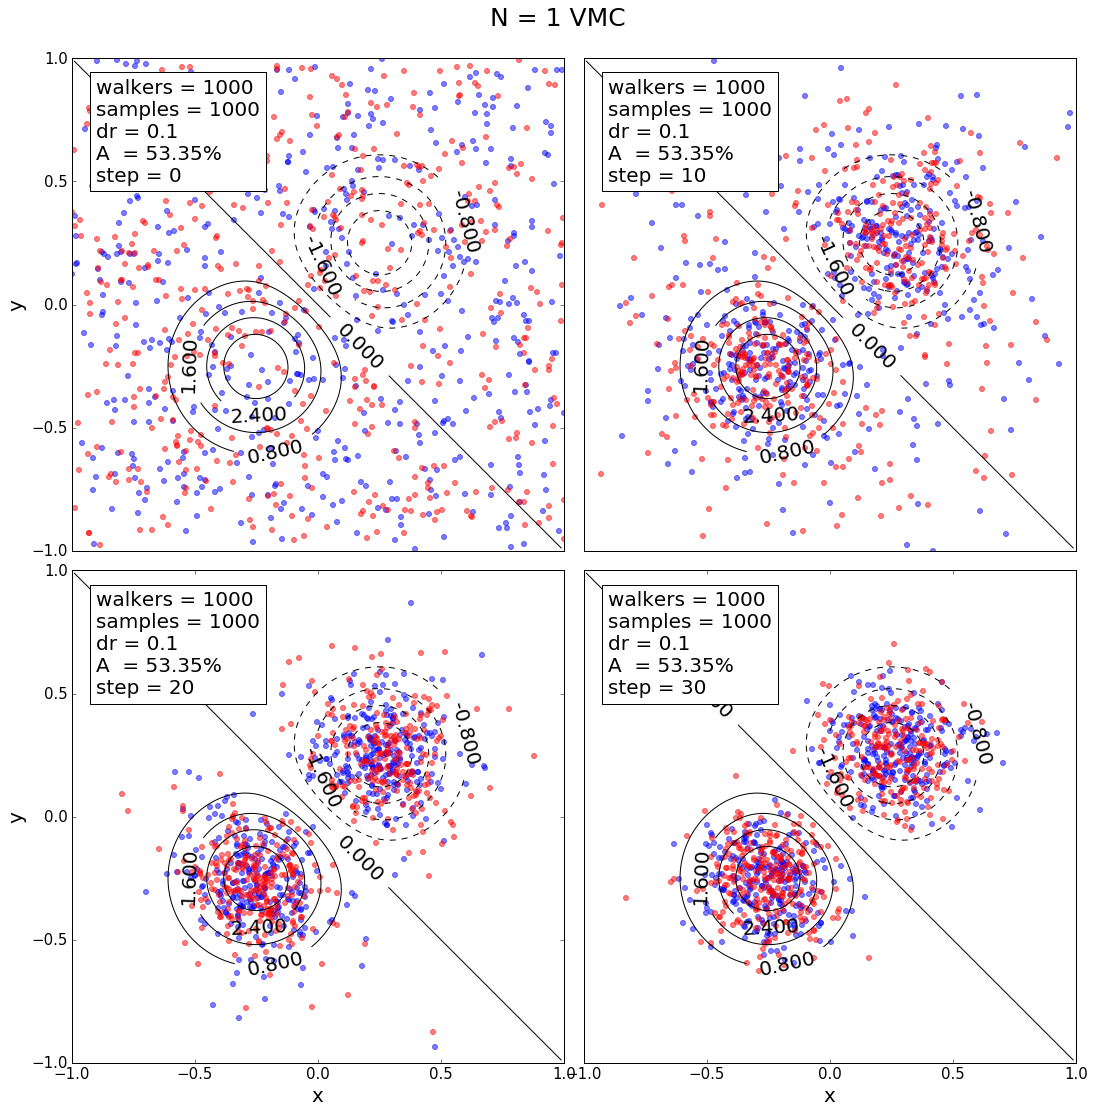

In [18]:
def plot_samples(samples, psi, limits=[]):
    ''' Plot the results of our Monte Carlo
        sampling along with the underlying
        probability distribution psi. Samples
        must be a numpy array in vstack format
        e.g. [[0.5, 0.3], [0.3, -0.3], ...]
        where the first half are species i
        and the second half are species j'. '''
    
    # set up a meshgrid
    dx = 0.01
    pad = 5
    if limits:
        xlow, xhigh = limits[0], limits[1]
        ylow, yhigh = limits[2], limits[3]
    else:
        xlow = np.min(samples)-pad 
        xhigh = np.max(samples)+pad
        ylow = np.min(samples)-pad
        yhigh = np.max(samples)+pad

    x = np.arange(xlow, xhigh, dx)
    y = np.arange(ylow, yhigh, dx)
    X, Y = np.meshgrid(x, y)

    # define Z as the value of the probability 
    # distribution psi at each 'vertex'
    # Z becomes a 2D Numpy array
    Z = psi(X, Y)
    
    # must be feeding in numpy arrays below
    # plot species i as blue points
    plt.scatter(samples[:int(len(samples)/2), 0],
                samples[:int(len(samples)/2), 1],
                alpha=0.5, s=25, color='blue')
    # plot species j' as blue points
    plt.scatter(samples[int(len(samples)/2):, 0],
                samples[int(len(samples)/2):, 1],
                alpha=0.5, s=25, color='red')
    CS = plt.contour(X, Y, Z, 10, colors='k')
    plt.clabel(CS, inline=1, fontsize=20)
    
    plt.xlim(xlow, xhigh)
    plt.ylim(ylow, yhigh)
    plt.xlabel('x', fontsize=20)
    plt.ylabel('y', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)


print('We took {0:d} samples with an average acceptance ratio of {1:.2f}%'
      .format(int(len(sample_stack)/Nparticles), acceptance))

box = dict(boxstyle='square', facecolor='white', alpha=1.0)

fig = plt.figure(figsize=(18,18))

# Making a 4 panel figure where the walkers are equilibrating over time
# will have to split samples into 4 sets
quads = np.array([samples[0:int(len(samples)/4)], samples[int(len(samples)/4):int(len(samples)/2)], 
                 samples[int(len(samples)/2):int(len(samples)*3/4)], samples[int(len(samples)*3/4):]])
quad_stack = [np.vstack((quads[i].T[0].ravel(), quads[i].T[1].ravel())).T
              for i in range(4)]
print('Taking one sample (containing', Nparticles, 'particles) every', m, 'steps')
for i in range(4):
    plt.subplot(2,2,i+1)
    plot_samples(quad_stack[i], psi, [-1, 1, -1, 1])
    plt.text(-0.9, 0.5, 'walkers = {0:d}\nsamples = {1:d}\ndr = {2:.1f}\nA  = {3:.2f}%\nstep = {4:d}'
                        .format(walkers, int(len(quad_stack[i])/Nparticles), dr, acceptance, int(i*len(quad_stack[0])/Nparticles*m/walkers)),
             fontsize=20, bbox=box, zorder=10)
    # Remove some x, y tick labels
    if i==0 or i==1:
        plt.xticks([])
        plt.xlabel('')
    if i==1 or i==3:
        plt.yticks([])
        plt.ylabel('')
    
    
plt.subplots_adjust(wspace=0.04)
plt.subplots_adjust(hspace=0.04)

plt.suptitle('N = '+str(Nparticles)+' VMC', y=0.94, fontsize=25)

# plt.savefig('figures/VMC_N_1_random_start.png',
#             bbox_inches = 'tight', dpi=144)
plt.show()

In this case, once the system has equilibrated, we sample $\Psi_V = \psi^2$ as expected.

### VMC script for calculating $E$

Now that we have a grip on sampling the many-body wave function, let's calcualte $E$. We'll plot it as a function of the step number $N_{steps}$.

A few new functions are added to the VMC algorithm:

In [66]:
def prob_density(R, N):
    ''' The square of the many body wave function
        Psi_V(R). '''

    # e.g. for N=4:
    # psi_v = psi(r_1) + psi(r_2) + psi(r_3) + psi(r_4)
    psi_v = sum([psi(R[n][0], R[n][1]) for n in range(N)])
    
    # Setting anything outside the box equal to zero
    # This will keep particles inside
    for coordinate in R.ravel():
        if abs(coordinate) > 1:
            psi_v = 0
    
    return np.float64(psi_v**2)

def Metroplis_algorithm_walkers(N, Nsteps, m, walkers, dr):
    ''' A Markov chain is constructed, using the
    Metropolis algorithm, that is comprised of
    samples of our probability density: psi(x,y).
    
    N - number of particles per box,
        must be an even number
    Nsteps - number of random moves to try
    m - will return a samples when i%m == 0
        in the loop over Nsteps,
        make sure Nsteps/m = integer
    walkers - number of unique Markov chains
              i.e., number of boxes
    dr - average size of moves (if uniform),
         controls the acceptance ratio '''
    
    # We'll want to return the average
    # acceptance ratio
    a_total = 0
    
    # Sample locations and E will be stored in a list
    samples, E_total = [], []
    
    # Get the starting configuration
    # and sample probability distribution
    # We'll start at a randomly
    # selected position for each walker
    r_prime = np.array(
              [[np.random.uniform(-1, 1, size=2) for n in range(N)]
               for w in range(walkers)])
    p_prime = np.array([prob_density(r_prime[w], N) for w in range(walkers)])
    
    # Initialize lists
    r = np.zeros(shape=r_prime.shape)
    p = np.zeros(shape=p_prime.shape)
    
    for i in range(Nsteps):
        # Initialize E to be averaged over all walkers
        E_walkers = 0
        
        for w in range(walkers):
            # Propose a random move: r'-> r
            r[w] = r_prime[w] + np.reshape(np.random.normal(loc=0, scale=dr,
                                                            size=len(r[w].ravel())),
                                           r[w].shape)
            # The probability distribution for each
            # walker is a float value found by taking a
            # sum of single-particle wave functions
            p[w] = prob_density(r[w], N)
        
            # Calculate the acceptance ratio
            # for the proposed move
            a = min(1, p[w]/p_prime[w])
            # update the total
            a_total += a
            
            # Check for acceptance
            p_prime[w], r_prime[w] = check_move(p_prime[w], p[w],
                                                r_prime[w], r[w])

            if i%m == 0:
                # Append sample coordinates
                # Must use np.copy for this to work properly
                samples.append(np.copy(r_prime[w]))
                # Calculate E 'energy' function
                E = calc_E_function(r_prime[w])
                E_walkers += E
        
        if i%m == 0:
            # Append the average E value over all walkers at step i
            E_total.append(E_walkers/walkers)
    
    return np.array(samples), a_total/Nsteps/walkers*100.0, E_total

def calc_E_function(R):
    ''' Input a numpy array R (the many-body configuration
        vector) containing the positions of each particle in
        the box. e.g. [[0.4, 0.3], [-0.3, -0.7], ...].
        Return the function E of the configuration.
        
        Note: the "kinetic" term T is made-up to avoid having
        to calcualte the actual kinetic energy. '''
    
    T, V = calc_T(R), calc_V(R)
    
    E = T + V
    
    return E 
    
def calc_T(R):
    ''' Input a numpy array R (the many-body configuration
        vector) containing the positions of each particle in
        the box. e.g. [[0.4, 0.3], [-0.3, -0.7], ...].
        Return the function T of the configuration.
        
        This term is made-up to avoid having
        to calcualte the actual kinetic energy. '''
    
    Ti, Tj = 0, 0
    
    # Sum over species i
    for r in R[:int(len(R)/2)]:
        Ti += r[0]*r[1]
        
    # Sum over species j'
    for r in R[int(len(R)/2):]:
        Tj += r[0]*r[1]

    T = Ti*Tj
    
    return T

def calc_V(R):
    ''' Input a numpy array R (the many-body configuration
        vector) containing the positions of each particle in
        the box. e.g. [[0.4, 0.3], [-0.3, -0.7], ...].
        Return the potential energy of the configuration.
        
        We'll take the first half of the array to be
        species i and the second half to be species j' and
        consider only cross-species interactions. '''
    
    # Define the two particle potential energy
    mu = 0.5
    sig = 0.1
    vpot = lambda r: -stats.norm.pdf((r-mu)/(sig))
    
    # Iterate over each pair
    V = 0
    # Using numpy matrix transpose .T
    Rx, Ry = R.T[0], R.T[1]
    N = len(R)
    for i in range(int(N/2)):
        for j in range(int(N/2),N):
            # If statement to avoid double counting
            if i <= (j-int(N/2)):
                r = np.sqrt((Rx.T[i] - Rx.T[j])**2
                           +(Ry.T[i] - Ry.T[j])**2)
                V += vpot(r)

    return V
    
    
def check_move(p_prime, p, r_prime, r):
    ''' The move will be accepted or rejected
        based on the ratio of p/p_prime and a
        random number. '''
    
    if p/p_prime >= 1:
        # Accept the move
        return p, r
   
    else:
        rand = np.random.uniform(0, 1)
        if p/p_prime + rand >= 1:
            # Accept the move
            return p, r
        else:
            # Reject the move
            return p_prime, r_prime

As a reminder, this is what our two-particle potential $v(r_{ij'})$ looks like:
<img src="figures/attractive_gausssian_potential.png" width="700" align="left">

#### Calculating $E$ for $N=4$ $\Psi_V$

Let's calcualte $E$ for $N=4$ with 200 walkers, as seen above, but now setting $m=1$ for illustration purposes [1] and running the simulation for much longer.

[2] - Setting $m=1$ means that $E$ was calculated for each step, but for actual calculations $m$ should be set much larger (e.g. 100, 200) so that the state has sufficient opportunity to change in between calculations of $E$.

Acceptance ratio: 52.522254734528275%
Shape of samples: (160000, 4, 2)
Shape of sample stack: (640000, 2)
x max/min: 0.99999532336 -0.999989250743
y max/min: 0.999992532483 -0.99999771121


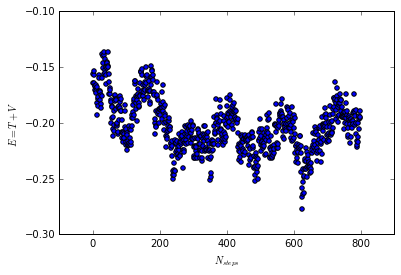

In [67]:
Nparticles, Nsteps, m, walkers, dr = 4, 800, 1, 200, 0.1
samples, acceptance, E_func = Metroplis_algorithm_walkers(Nparticles, Nsteps, m, walkers, dr)
sample_stack = np.vstack((samples.T[0].ravel(), samples.T[1].ravel())).T

print('Acceptance ratio: {}%'.format(acceptance))
print('Shape of samples: {}'.format(samples.shape))
print('Shape of sample stack: {}'.format(sample_stack.shape))
print('x max/min:', max(sample_stack.T[0]), min(sample_stack.T[0]))
print('y max/min:', max(sample_stack.T[1]), min(sample_stack.T[1]))
plt.scatter([i*m for i in range(int(Nsteps/m))], E_func)
plt.ylabel('$E = T + V$')
plt.xlabel('$N_{steps}$')

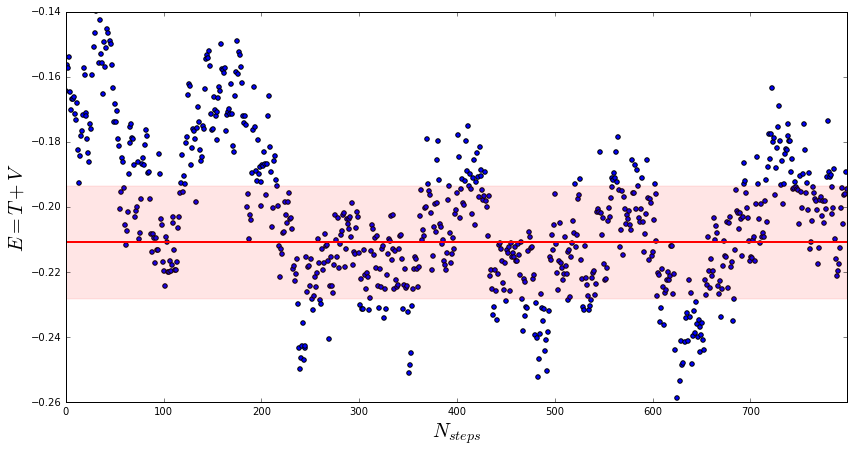

Average E = -0.210924334772 +/- 0.0173341064426


In [71]:
fig = plt.figure(figsize=(14,7))

ax = plt.subplot()

x = [i*m for i in range(int(Nsteps/m))]
ax.scatter(x, E_func)
ax.set_ylabel('$E = T + V$', fontsize=20)
ax.set_xlabel('$N_{steps}$', fontsize=20)
ax.set_xlim(0,max(x))
ax.set_ylim(-0.26, -0.14)

# How many steps for equilibration
N_eq = int(200/m)
E_average = sum(E_func[N_eq:])/len(E_func[N_eq:])

# Calculate the error as the standard deviation
E_error = sum((E_func[N_eq:] - E_average)**2)
E_error = np.sqrt(E_error/len(E_func[N_eq:]))

ax.axhline(y=E_average, color='r', lw=2)
ax.fill_between(x, E_average+E_error, E_average-E_error,
               color='red', alpha=0.1)

# plt.savefig('figures/E_calc_N_4_800steps_200walkers.png', bbox_inches='tight', dpi=144)

plt.show()

print('Average E =', E_average, '+/-', E_error)

In this case we calculate an average energy of -0.211 +/- 0.017, where the first 200 steps have been excluded so we only average over the equilibrated system. The error, as shown by the red band around the average, is calculated as the sample standard deviation of $E$ [3]:

$$ E_{error} = \sqrt{\frac{1}{N} \sum_{i=0}^N (E_i - E_{average})^2} $$

[3] - In practice, the error on Monte Carlo calculations is often given by the standard deviation divided by $\sqrt{N}$. Otherwise the error does not decrease as $N$ increases, which should intuitively be the case because we are building confidence in the calculation as the simulation is run longer. For more information see this article: http://www.tqmp.org/RegularArticles/vol10-2/p107/p107.pdf, specifically the first few equations and Figure 1.

Let's try increasing the number of walkers to see if we can reduce the error.

Acceptance ratio: 52.5616842471406%
Shape of samples: (1600000, 4, 2)
Shape of sample stack: (6400000, 2)
x max/min: 0.999999673978 -0.999998019402
y max/min: 0.999999036736 -0.999999590934


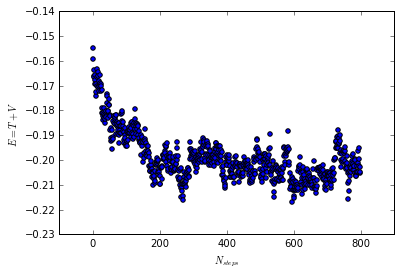

In [46]:
Nparticles, Nsteps, m, walkers, dr = 4, 800, 1, 2000, 0.1
samples, acceptance, E_func = Metroplis_algorithm_walkers(Nparticles, Nsteps, m, walkers, dr)
sample_stack = np.vstack((samples.T[0].ravel(), samples.T[1].ravel())).T

print('Acceptance ratio: {}%'.format(acceptance))
print('Shape of samples: {}'.format(samples.shape))
print('Shape of sample stack: {}'.format(sample_stack.shape))
print('x max/min:', max(sample_stack.T[0]), min(sample_stack.T[0]))
print('y max/min:', max(sample_stack.T[1]), min(sample_stack.T[1]))
plt.scatter([i*m for i in range(int(Nsteps/m))], E_func)
plt.ylabel('$E = T + V$')
plt.xlabel('$N_{steps}$')

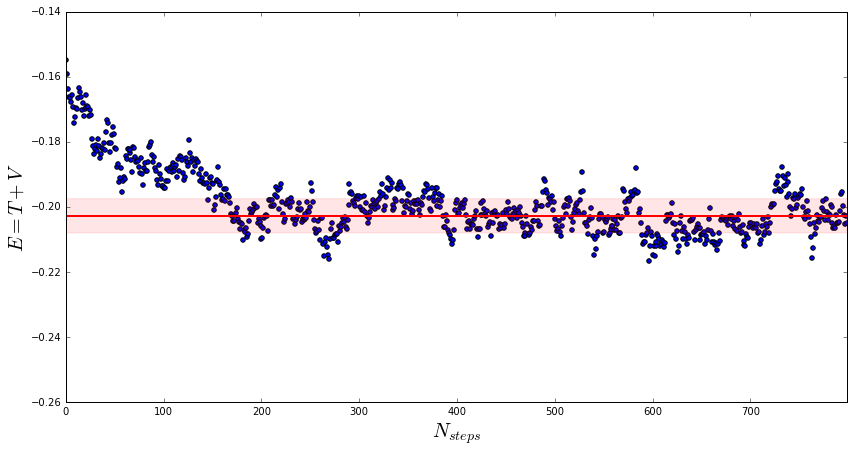

Average E = -0.202744298872 +/- 0.00525324398979


In [49]:
fig = plt.figure(figsize=(14,7))

ax = plt.subplot()

x = [i*m for i in range(int(Nsteps/m))]
ax.scatter(x, E_func)
ax.set_ylabel('$E = T + V$', fontsize=20)
ax.set_xlabel('$N_{steps}$', fontsize=20)
ax.set_xlim(0,max(x))
ax.set_ylim(-0.26, -0.14)

# How many steps for equilibration
N_eq = int(200/m)
E_average = sum(E_func[N_eq:])/len(E_func[N_eq:])

# Calculate the error as the standard deviation
E_error = sum((E_func[N_eq:] - E_average)**2)
E_error = np.sqrt(E_error/len(E_func[N_eq:]))

ax.axhline(y=E_average, color='r', lw=2)
ax.fill_between(x, E_average+E_error, E_average-E_error,
               color='red', alpha=0.1)

# plt.savefig('figures/E_calc_N_4_800steps_2000walkers.png', bbox_inches='tight', dpi=144)

plt.show()

print('Average E =', E_average, '+/-', E_error)

Now we calculate E = -0.202 +/- 0.005, where the error in this case has been nearly quartered because we used ten times as many walkers.

### Starting particles near edge of box to make it harder to equilibrate
You may have noticed how the system seems to equilibrate almost immediately. This is because the starting configurations are randomly distributed about the box. What if we instead place the particles near the edges (far away from where $\psi$ is large) to start?

In [72]:
def prob_density(R, N):
    ''' The square of the many body wave function
        Psi_V(R). '''

    # e.g. for N=4:
    # psi_v = psi(r_1) + psi(r_2) + psi(r_3) + psi(r_4)
    psi_v = (sum([psi(R[n][0], R[n][1]) for n in range(N)]))**2
    
    # Setting anything outside the box equal to zero
    # This will keep particles inside
    for coordinate in R.ravel():
        if abs(coordinate) > 1:
            psi_v = 0
    
    return np.float64(psi_v)

def Metroplis_algorithm_walkers(N, Nsteps, m, walkers, dr):
    ''' A Markov chain is constructed, using the
    Metropolis algorithm, that is comprised of
    samples of our probability density: psi(x,y).
    
    N - number of particles per box,
        must be an even number
    Nsteps - number of random moves to try
    m - will return a samples when i%m == 0
        in the loop over Nsteps,
        make sure Nsteps/m = integer
    walkers - number of unique Markov chains
              i.e., number of boxes
    dr - average size of moves (if uniform),
         controls the acceptance ratio '''
    
    # We'll want to return the average
    # acceptance ratio
    a_total = 0
    
    # Sample locations and E will be stored in a list
    samples, E_total = [], []
    
    # Get the starting configuration
    # and sample probability distribution
    # We can start at a randomly
    # selected position for each walker
    # np.random.uniform(-1, 1, size=2)
    # 
    # Instead we are starting near the edge of
    # the box (where T is large) so we can see the 
    # equilibration in the calculation of E
    r_prime = np.array(
              [[np.random.choice([0.9,-0.9], size=2)+np.random.uniform(-0.01, 0.01, size=2)
                for n in range(N)]
               for w in range(walkers)])
    p_prime = np.array([prob_density(r_prime[w], N) for w in range(walkers)])
    
    # Initialize lists
    r = np.zeros(shape=r_prime.shape)
    p = np.zeros(shape=p_prime.shape)
    
    for i in range(Nsteps):
        # Initialize E to be averaged over all walkers
        E_walkers = 0
        
        for w in range(walkers):
            # Propose a random move: r'-> r
            r[w] = r_prime[w] + np.reshape(np.random.normal(loc=0, scale=dr,
                                                            size=len(r[w].ravel())),
                                           r[w].shape)
            # The probability distribution for each
            # walker is a float value found by taking a
            # sum of single-particle wave functions
            p[w] = prob_density(r[w], N)
        
            # Calculate the acceptance ratio
            # for the proposed move
            a = min(1, p[w]/p_prime[w])
            # update the total
            a_total += a
            
            # Check for acceptance
            p_prime[w], r_prime[w] = check_move(p_prime[w], p[w],
                                                r_prime[w], r[w])

            if i%m == 0:
                # Append sample coordinates
                # Must use np.copy for this to work properly
                samples.append(np.copy(r_prime[w]))
                # Calculate E 'energy' function
                E = calc_E_function(r_prime[w])
                E_walkers += E
        
        if i%m == 0:
            # Append the average E value over all walkers at step i
            E_total.append(E_walkers/walkers)
    
    return np.array(samples), a_total/Nsteps/walkers*100.0, E_total

Acceptance ratio: 50.37550075327122%
Shape of samples: (1600000, 4, 2)
Shape of sample stack: (6400000, 2)
x max/min: 0.999999756208 -0.999999944067
y max/min: 0.999998021118 -0.999999347572


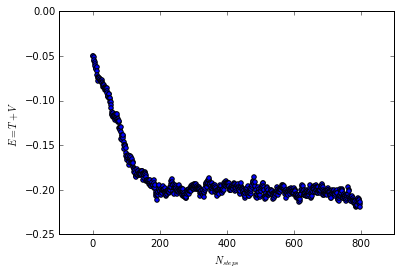

In [73]:
Nparticles, Nsteps, m, walkers, dr = 4, 800, 1, 2000, 0.1
samples, acceptance, E_func = Metroplis_algorithm_walkers(Nparticles, Nsteps, m, walkers, dr)
sample_stack = np.vstack((samples.T[0].ravel(), samples.T[1].ravel())).T

print('Acceptance ratio: {}%'.format(acceptance))
print('Shape of samples: {}'.format(samples.shape))
print('Shape of sample stack: {}'.format(sample_stack.shape))
print('x max/min:', max(sample_stack.T[0]), min(sample_stack.T[0]))
print('y max/min:', max(sample_stack.T[1]), min(sample_stack.T[1]))
plt.scatter([i*m for i in range(int(Nsteps/m))], E_func)
plt.ylabel('$E = T + V$')
plt.xlabel('$N_{steps}$')

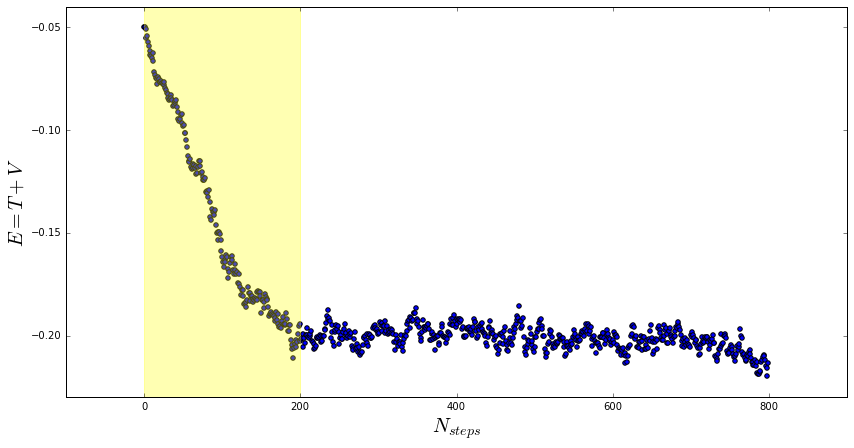

In [76]:
fig = plt.figure(figsize=(14,7))

ax = plt.subplot()

x = [i*m for i in range(int(Nsteps/m))]
ax.scatter(x, E_func)
ax.set_ylabel('$E = T + V$', fontsize=20)
ax.set_xlabel('$N_{steps}$', fontsize=20)
#ax.set_xlim(0, 400)
ax.set_ylim(-0.23, -0.04)

ax.fill_betweenx([-1, 0], 0, 200, color='yellow', alpha=0.3)

plt.show()

#### Plotting KDEs for the equilibration

We took 1600000 samples with an average acceptance ratio of 50.38%


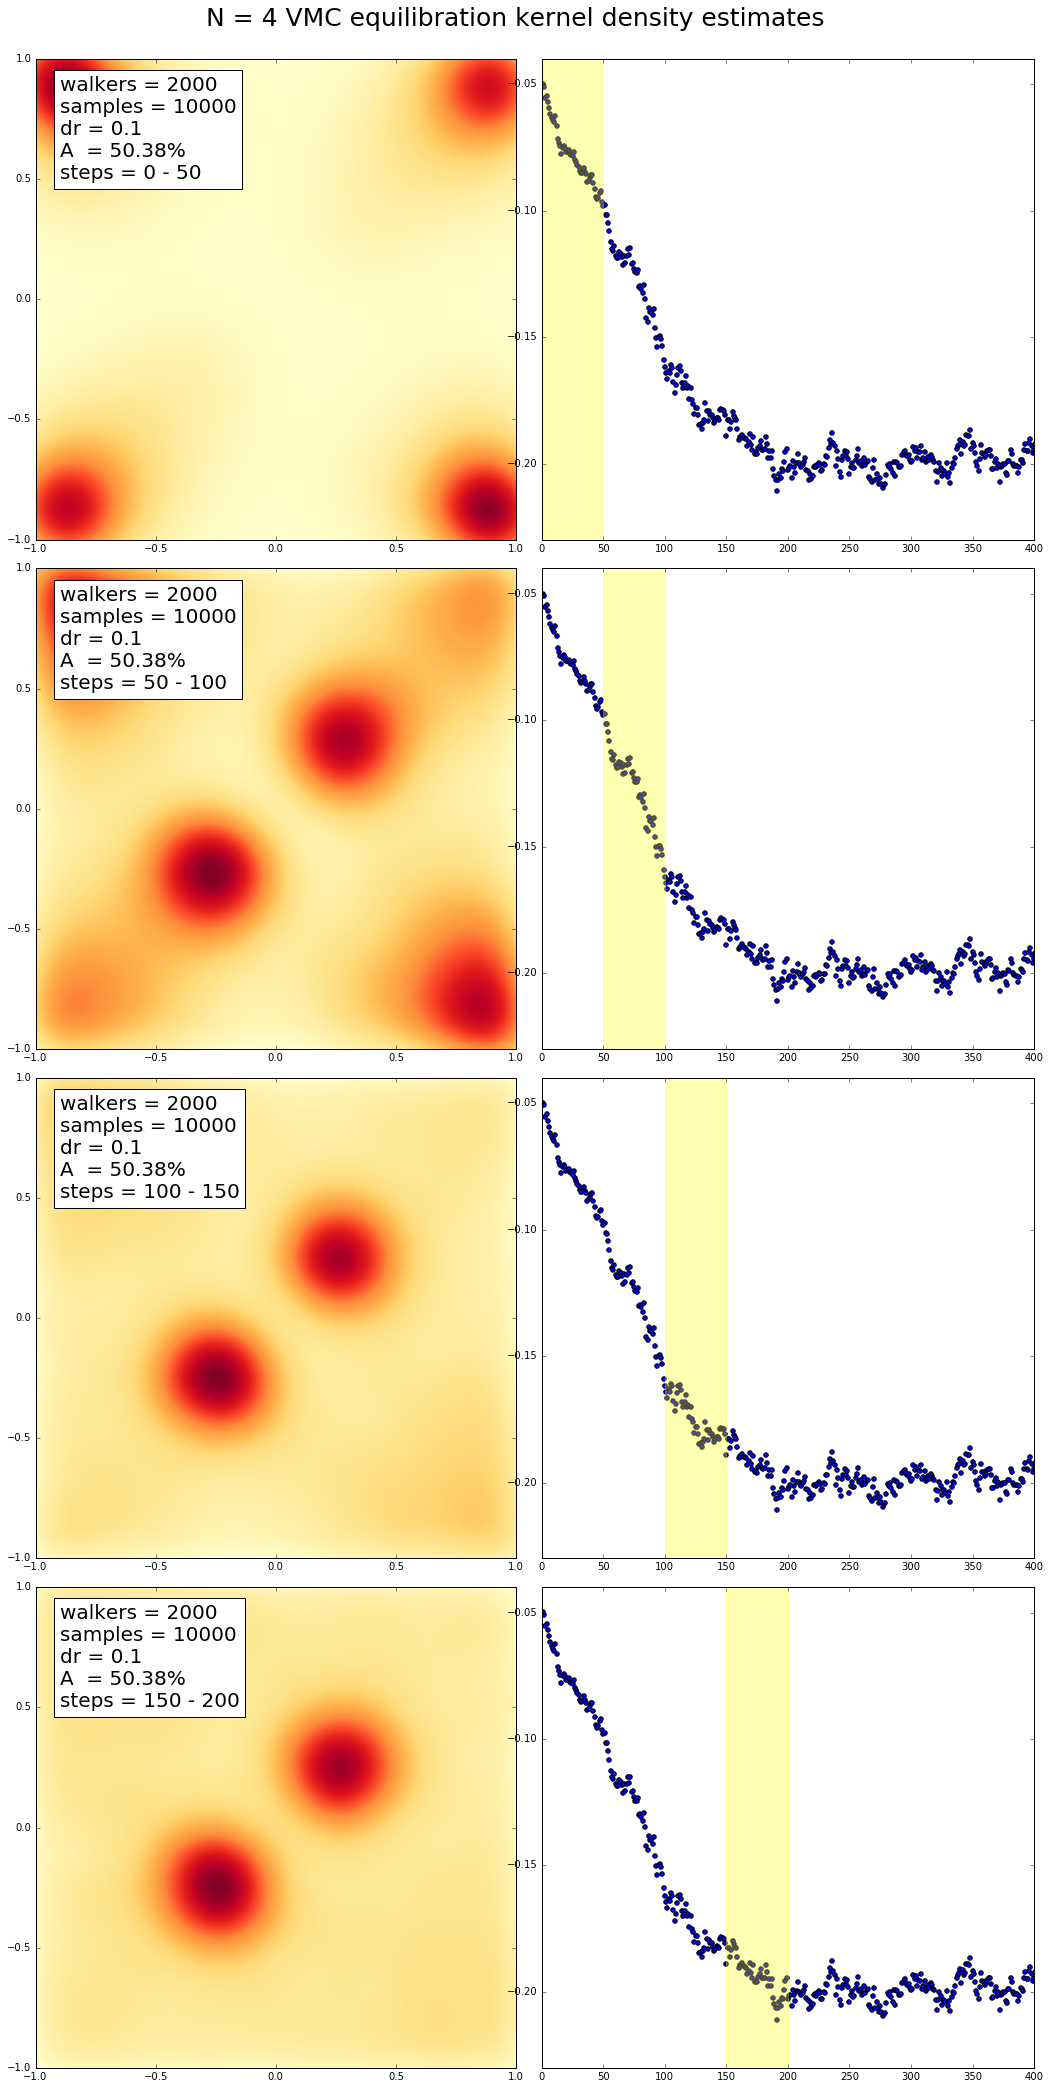

In [77]:
# def plot_samples(ax, samples, psi, limits=[]):
#     ''' Plot the results of our Monte Carlo
#         sampling along with the underlying
#         probability distribution psi. Samples
#         must be a numpy array in vstack format
#         e.g. [[0.5, 0.3], [0.3, -0.3], ...]
#         where the first half are species i
#         and the second half are species j'. '''
    
#     # set up a meshgrid
#     dx = 0.01
#     pad = 5
#     if limits:
#         xlow, xhigh = limits[0], limits[1]
#         ylow, yhigh = limits[2], limits[3]
#     else:
#         xlow = np.min(samples)-pad 
#         xhigh = np.max(samples)+pad
#         ylow = np.min(samples)-pad
#         yhigh = np.max(samples)+pad

#     x = np.arange(xlow, xhigh, dx)
#     y = np.arange(ylow, yhigh, dx)
#     X, Y = np.meshgrid(x, y)

#     # define Z as the value of the probability 
#     # distribution psi at each 'vertex'
#     # Z becomes a 2D Numpy array
#     Z = psi(X, Y)
    
#     # must be feeding in numpy arrays below
#     # plot species i as blue points
#     ax.scatter(samples[:int(len(samples)/2), 0],
#                 samples[:int(len(samples)/2), 1],
#                 alpha=0.3, s=25, color='red')
#     # plot species j' as blue points
#     ax.scatter(samples[int(len(samples)/2):, 0],
#                 samples[int(len(samples)/2):, 1],
#                 alpha=0.3, s=25, color='blue')
#     CS = ax.contour(X, Y, Z, 10, colors='k')
#     ax.clabel(CS, inline=1, fontsize=20)
    
#     ax.set_xlim(xlow, xhigh)
#     ax.set_ylim(ylow, yhigh)
#     ax.set_xlabel('x', fontsize=20)
#     ax.set_ylabel('y', fontsize=20)
#     ax.tick_params(axis='both', which='major', labelsize=15)
    
def plot_kde(ax, samples):
    x = np.arange(-1, 1, 0.01)
    y = np.arange(-1, 1, 0.01)
    X, Y = np.meshgrid(x, y)
    xy = np.vstack([X.ravel(), Y.ravel()])
    # sample_stack = np.vstack((samples.T[0].ravel(), samples.T[1].ravel())).T
    kde = stats.gaussian_kde(samples)
    z = kde(xy).T
    Z = np.reshape(z, X.shape)
    ax.imshow(np.rot90(Z), cmap=plt.cm.YlOrRd,
              extent=[-1, 1, -1, 1])

print('We took {0:d} samples with an average acceptance ratio of {1:.2f}%'
      .format(int(len(sample_stack)/Nparticles), acceptance))

box = dict(boxstyle='square', facecolor='white', alpha=1.0)

fig = plt.figure(figsize=(18,36))

# Making an 8 panel figure where the walkers
# are quilibrating over time

# Split up samples into groups and skip some
# The kernel density estimate may not work
# if there are duplicate samples so skipping
# some may be necessary
w, skip = 0, 10
plt_samples = []
samp = samples[:int(len(samples)/4)]
for i in range(int(len(samp)/skip)):
    plt_samples.append(samp[w:walkers+w])
    w += skip*walkers
plt_samples = np.concatenate(plt_samples)
quads = np.array([plt_samples[0:int(len(plt_samples)/4)],
                  plt_samples[int(len(plt_samples)/4):int(len(plt_samples)/2)], 
                  plt_samples[int(len(plt_samples)/2):int(len(plt_samples)*3/4)],
                  plt_samples[int(len(plt_samples)*3/4):]])
quad_stack = [np.vstack((quads[i].T[0].ravel(), quads[i].T[1].ravel())).T
              for i in range(4)]

j = 0
for i in range(8):
    ax = plt.subplot(4,2,i+1)
    if i%2==0:
        # plot_samples(ax, quad_stack[j], psi, [-1, 1, -1, 1])
        plot_kde(ax, quad_stack[j].T)
        plt.text(-0.9, 0.5, 'walkers = {0:d}\nsamples = {1:d}\ndr = {2:.1f}\nA  = {3:.2f}%\nsteps = {4:d} - {5:d}'
                            .format(walkers, int(len(quad_stack[j])/Nparticles), dr, acceptance, int(j*len(quad_stack[0])/Nparticles/walkers*skip*m), int((j+1)*len(quad_stack[0])/Nparticles/walkers*skip*m)),
                 fontsize=20, bbox=box, zorder=10)
        j += 1
    else:
        x = [i*m for i in range(int(Nsteps/m))]
        ax.scatter(x, E_func)
        ax.set_xlim(0, 400)
        ax.set_ylim(-0.23, -0.04)
        ax.fill_betweenx([-1, 0], (j-1)*50, j*50, color='yellow', alpha=0.3)

#     ax.set_ylabel('$E = T + V$', fontsize=20)
#     ax.set_xlabel('$N_{steps}$', fontsize=20)
    
#     # Remove some x, y tick labels
#     if i==0 or i==1:
#         plt.xticks([])
#         plt.xlabel('')
#     if i==1 or i==3:
#         plt.yticks([])
#         plt.ylabel('')
    
    
plt.subplots_adjust(wspace=0.04)
plt.subplots_adjust(hspace=0.06)

plt.suptitle('N = '+str(Nparticles)+' VMC equilibration kernel density estimates', y=0.92, fontsize=25)

# plt.savefig('figures/VMC_N_4_edges_start_kde.png',
#             bbox_inches = 'tight', dpi=144)
plt.show()

We took 1600000 samples with an average acceptance ratio of 50.38%


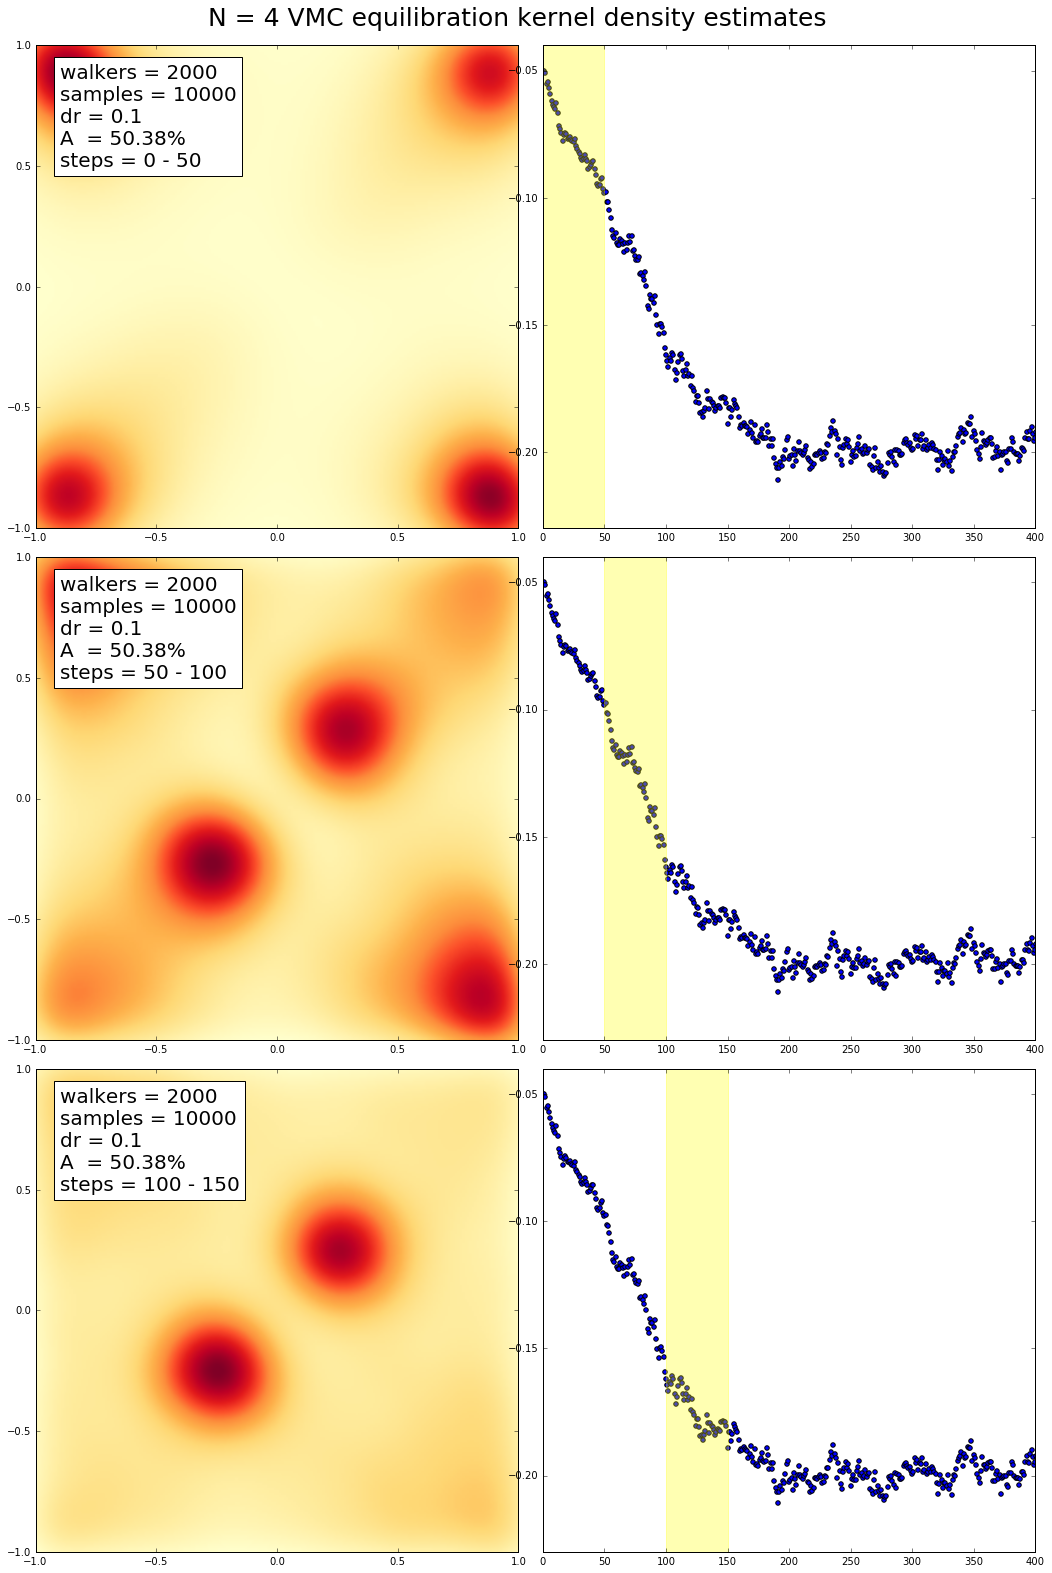

In [80]:
# def plot_samples(ax, samples, psi, limits=[]):
#     ''' Plot the results of our Monte Carlo
#         sampling along with the underlying
#         probability distribution psi. Samples
#         must be a numpy array in vstack format
#         e.g. [[0.5, 0.3], [0.3, -0.3], ...]
#         where the first half are species i
#         and the second half are species j'. '''
    
#     # set up a meshgrid
#     dx = 0.01
#     pad = 5
#     if limits:
#         xlow, xhigh = limits[0], limits[1]
#         ylow, yhigh = limits[2], limits[3]
#     else:
#         xlow = np.min(samples)-pad 
#         xhigh = np.max(samples)+pad
#         ylow = np.min(samples)-pad
#         yhigh = np.max(samples)+pad

#     x = np.arange(xlow, xhigh, dx)
#     y = np.arange(ylow, yhigh, dx)
#     X, Y = np.meshgrid(x, y)

#     # define Z as the value of the probability 
#     # distribution psi at each 'vertex'
#     # Z becomes a 2D Numpy array
#     Z = psi(X, Y)
    
#     # must be feeding in numpy arrays below
#     # plot species i as blue points
#     ax.scatter(samples[:int(len(samples)/2), 0],
#                 samples[:int(len(samples)/2), 1],
#                 alpha=0.3, s=25, color='red')
#     # plot species j' as blue points
#     ax.scatter(samples[int(len(samples)/2):, 0],
#                 samples[int(len(samples)/2):, 1],
#                 alpha=0.3, s=25, color='blue')
#     CS = ax.contour(X, Y, Z, 10, colors='k')
#     ax.clabel(CS, inline=1, fontsize=20)
    
#     ax.set_xlim(xlow, xhigh)
#     ax.set_ylim(ylow, yhigh)
#     ax.set_xlabel('x', fontsize=20)
#     ax.set_ylabel('y', fontsize=20)
#     ax.tick_params(axis='both', which='major', labelsize=15)
    
def plot_kde(ax, samples):
    x = np.arange(-1, 1, 0.01)
    y = np.arange(-1, 1, 0.01)
    X, Y = np.meshgrid(x, y)
    xy = np.vstack([X.ravel(), Y.ravel()])
    # sample_stack = np.vstack((samples.T[0].ravel(), samples.T[1].ravel())).T
    kde = stats.gaussian_kde(samples)
    z = kde(xy).T
    Z = np.reshape(z, X.shape)
    ax.imshow(np.rot90(Z), cmap=plt.cm.YlOrRd,
              extent=[-1, 1, -1, 1])

print('We took {0:d} samples with an average acceptance ratio of {1:.2f}%'
      .format(int(len(sample_stack)/Nparticles), acceptance))

box = dict(boxstyle='square', facecolor='white', alpha=1.0)

fig = plt.figure(figsize=(18,27))

# Making an 8 panel figure where the walkers
# are quilibrating over time

# Split up samples into groups and skip some
# The kernel density estimate may not work
# if there are duplicate samples so skipping
# some may be necessary
w, skip = 0, 10
plt_samples = []
samp = samples[:int(len(samples)/4)]
for i in range(int(len(samp)/skip)):
    plt_samples.append(samp[w:walkers+w])
    w += skip*walkers
plt_samples = np.concatenate(plt_samples)
quads = np.array([plt_samples[0:int(len(plt_samples)/4)],
                  plt_samples[int(len(plt_samples)/4):int(len(plt_samples)/2)], 
                  plt_samples[int(len(plt_samples)/2):int(len(plt_samples)*3/4)],
                  plt_samples[int(len(plt_samples)*3/4):]])
quad_stack = [np.vstack((quads[i].T[0].ravel(), quads[i].T[1].ravel())).T
              for i in range(4)]

j = 0
for i in range(6):
    ax = plt.subplot(3,2,i+1)
    if i%2==0:
        # plot_samples(ax, quad_stack[j], psi, [-1, 1, -1, 1])
        plot_kde(ax, quad_stack[j].T)
        plt.text(-0.9, 0.5, 'walkers = {0:d}\nsamples = {1:d}\ndr = {2:.1f}\nA  = {3:.2f}%\nsteps = {4:d} - {5:d}'
                            .format(walkers, int(len(quad_stack[j])/Nparticles), dr, acceptance, int(j*len(quad_stack[0])/Nparticles/walkers*skip*m), int((j+1)*len(quad_stack[0])/Nparticles/walkers*skip*m)),
                 fontsize=20, bbox=box, zorder=10)
        j += 1
    else:
        x = [i*m for i in range(int(Nsteps/m))]
        ax.scatter(x, E_func)
        ax.set_xlim(0, 400)
        ax.set_ylim(-0.23, -0.04)
        ax.fill_betweenx([-1, 0], (j-1)*50, j*50, color='yellow', alpha=0.3)

#     ax.set_ylabel('$E = T + V$', fontsize=20)
#     ax.set_xlabel('$N_{steps}$', fontsize=20)
    
#     # Remove some x, y tick labels
#     if i==0 or i==1:
#         plt.xticks([])
#         plt.xlabel('')
#     if i==1 or i==3:
#         plt.yticks([])
#         plt.ylabel('')
    
    
plt.subplots_adjust(wspace=0.04)
plt.subplots_adjust(hspace=0.06)

plt.suptitle('N = '+str(Nparticles)+' VMC equilibration kernel density estimates', y=0.92, fontsize=25)

# plt.savefig('figures/VMC_N_4_edges_start_kde_3_panel.png',
#             bbox_inches = 'tight', dpi=144)
plt.show()

### Variational theorem

The usefulness of VMC for quantum mechanical problems has to do with the variational theorem. In words, this theorem says that the energy expectation value (denoted $\langle \hat{H} \rangle$ for short) is minimized by the *true ground state wave function of the system*. This can be written mathematically as follows:

$$ \langle \hat{H} \rangle \equiv \langle \Psi_V~|~\hat{H}~|~\Psi_V \rangle \geq E_0, $$

where $E_0$ is the ground state energy of the system. A proof can be found at the bottom of page 60 of [my masters thesis](https://www.physics.uoguelph.ca/Nucweb/theses/Galea_Alexander_201601_Msc.pdf). The triple-bar equals sign simply means "is defined as", what's important is the other part of the equation.

If the name of the game is to find the ground state energy, which is often the case, then a good estimate can be achieved using VMC. A $\Psi_V$ can include variable parameters to optimize, which is done by calculating $\langle \hat{H} \rangle$ for a particular set of parameters (the same way we've calcualted $\langle E \rangle$ in this post) and repeating for different parameters until the lowest value is found. The resulting energy estimate will be an upper bound to the true ground state energy of the system.

### Calculating $E$ with a different many-body wave function $\Psi_V$

To show how changing $\Psi_V$ can impact the calculation of $E$ we'll adjust the wave function:
$$ \Psi_V(\mathbf{R}) = \sum_i^{N/2} \psi_1(\mathbf{r}_i) + \sum_{j'}^{N/2} \psi_2(\mathbf{r}_{j'}), $$
where the two species $i$ and $j'$ (which are equal in number) have different single-particle wave functions. We'll define $\psi_1(\mathbf{r})$ as the left gaussian (looking back to the first figure) and $\psi_2(\mathbf{r})$ as the right one.

In [63]:
def psi_1(x, y):
    ''' A single-particle wave function for species i. '''
    g1 = lambda x, y: mlab.bivariate_normal(x, y, 0.2, 0.2, -0.25, -0.25, 0)
    return g1(x, y)

def psi_2(x, y):
    ''' A single-particle wave function for species j'. '''
    g2 = lambda x, y: -mlab.bivariate_normal(x, y, 0.2, 0.2, 0.25, 0.25, 0)
    return g2(x, y)

This should have the efffect of separating the two species of particles. I wonder if $E$ will become larger or smaller?

For $N=4$ we have:
$$ \Psi_V(\mathbf{R}) = \psi_1(\mathbf{r}_1)+\psi_1(\mathbf{r}_2)+\psi_2(\mathbf{r}_{1'})+\psi_2(\mathbf{r}_{2'}), $$

taking two particles from each walker to be of species $i$ and two of species $j'$ (as was also done for the first $\Psi_V$). The new probability density function will be:

In [81]:
def prob_density(R, N):
    ''' The square of the many body wave function
        Psi_V(R). '''

    psi_v = sum([psi_1(R[n][0], R[n][1]) for n in range(int(N/2))]) + \
            sum([psi_2(R[n][0], R[n][1]) for n in range(int(N/2),N)])
    
    # Setting anything outside the box equal to zero
    # This will keep particles inside
    for coordinate in R.ravel():
        if abs(coordinate) > 1:
            psi_v = 0
    
    return np.float64(psi_v**2)

This cell is a copy of the `Metropolis_algorithm_walkers` function where $E$ is computed and the initial configurations are random.

In [82]:
def Metroplis_algorithm_walkers(N, Nsteps, m, walkers, dr):
    ''' A Markov chain is constructed, using the
    Metropolis algorithm, that is comprised of
    samples of our probability density: psi(x,y).
    
    N - number of particles per box,
        must be an even number
    Nsteps - number of random moves to try
    m - will return a samples when i%m == 0
        in the loop over Nsteps,
        make sure Nsteps/m = integer
    walkers - number of unique Markov chains
              i.e., number of boxes
    dr - average size of moves (if uniform),
         controls the acceptance ratio '''
    
    # We'll want to return the average
    # acceptance ratio
    a_total = 0
    
    # Sample locations and E will be stored in a list
    samples, E_total = [], []
    
    # Get the starting configuration
    # and sample probability distribution
    # We'll start at a randomly
    # selected position for each walker
    r_prime = np.array(
              [[np.random.uniform(-1, 1, size=2) for n in range(N)]
               for w in range(walkers)])
    p_prime = np.array([prob_density(r_prime[w], N) for w in range(walkers)])
    
    # Initialize lists
    r = np.zeros(shape=r_prime.shape)
    p = np.zeros(shape=p_prime.shape)
    
    for i in range(Nsteps):
        # Initialize E to be averaged over all walkers
        E_walkers = 0
        
        for w in range(walkers):
            # Propose a random move: r'-> r
            r[w] = r_prime[w] + np.reshape(np.random.normal(loc=0, scale=dr,
                                                            size=len(r[w].ravel())),
                                           r[w].shape)
            # The probability distribution for each
            # walker is a float value found by taking a
            # sum of single-particle wave functions
            p[w] = prob_density(r[w], N)
        
            # Calculate the acceptance ratio
            # for the proposed move
            a = min(1, p[w]/p_prime[w])
            # update the total
            a_total += a
            
            # Check for acceptance
            p_prime[w], r_prime[w] = check_move(p_prime[w], p[w],
                                                r_prime[w], r[w])

            if i%m == 0:
                # Append sample coordinates
                # Must use np.copy for this to work properly
                samples.append(np.copy(r_prime[w]))
                # Calculate E 'energy' function
                E = calc_E_function(r_prime[w])
                E_walkers += E
        
        if i%m == 0:
            # Append the average E value over all walkers at step i
            E_total.append(E_walkers/walkers)
    
    return np.array(samples), a_total/Nsteps/walkers*100.0, E_total

Acceptance ratio: 50.11132388897174%
Shape of samples: (4000, 4, 2)
Shape of sample stack: (16000, 2)
x max/min: 0.999951677981 -0.99994790792
y max/min: 0.999583799383 -0.999985485211


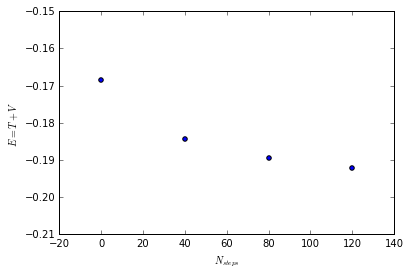

In [83]:
Nparticles, Nsteps, m, walkers, dr = 4, 160, 40, 1000, 0.1
samples, acceptance, E_func = Metroplis_algorithm_walkers(Nparticles, Nsteps, m, walkers, dr)
sample_stack = np.vstack((samples.T[0].ravel(), samples.T[1].ravel())).T

print('Acceptance ratio: {}%'.format(acceptance))
print('Shape of samples: {}'.format(samples.shape))
print('Shape of sample stack: {}'.format(sample_stack.shape))
print('x max/min:', max(sample_stack.T[0]), min(sample_stack.T[0]))
print('y max/min:', max(sample_stack.T[1]), min(sample_stack.T[1]))
plt.scatter([i*m for i in range(int(Nsteps/m))], E_func)
plt.ylabel('$E = T + V$')
plt.xlabel('$N_{steps}$')

We took 4000 samples with an average acceptance ratio of 50.11%
Taking one sample (containing 4 particles) every 40 steps


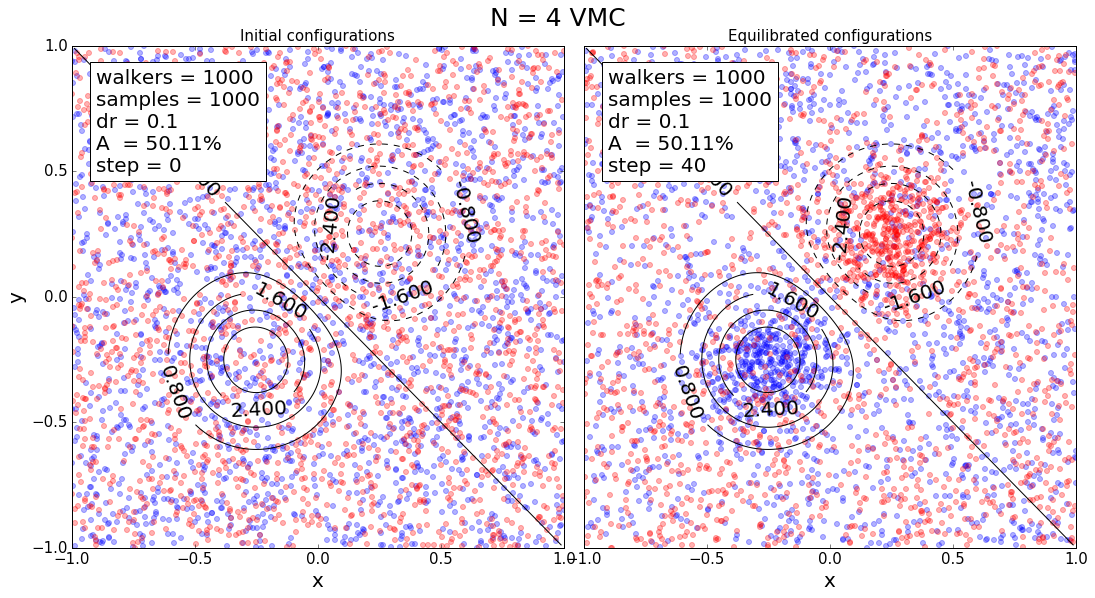

In [84]:
def plot_samples(samples, psi, limits=[]):
    ''' Plot the results of our Monte Carlo
        sampling along with the underlying
        probability distribution psi. Samples
        must be a numpy array in vstack format
        e.g. [[0.5, 0.3], [0.3, -0.3], ...]
        where the first half are species i
        and the second half are species j'. '''
    
    # set up a meshgrid
    dx = 0.01
    pad = 5
    if limits:
        xlow, xhigh = limits[0], limits[1]
        ylow, yhigh = limits[2], limits[3]
    else:
        xlow = np.min(samples)-pad 
        xhigh = np.max(samples)+pad
        ylow = np.min(samples)-pad
        yhigh = np.max(samples)+pad

    x = np.arange(xlow, xhigh, dx)
    y = np.arange(ylow, yhigh, dx)
    X, Y = np.meshgrid(x, y)

    # define Z as the value of the probability 
    # distribution psi at each 'vertex'
    # Z becomes a 2D Numpy array
    Z = psi(X, Y)
    
    # must be feeding in numpy arrays below
    # plot species i as blue points
    plt.scatter(samples[:int(len(samples)/2), 0],
                samples[:int(len(samples)/2), 1],
                alpha=0.3, s=25, color='blue')
    # plot species j' as blue points
    plt.scatter(samples[int(len(samples)/2):, 0],
                samples[int(len(samples)/2):, 1],
                alpha=0.3, s=25, color='red')
    CS = plt.contour(X, Y, Z, 10, colors='k')
    plt.clabel(CS, inline=1, fontsize=20)
    
    plt.xlim(xlow, xhigh)
    plt.ylim(ylow, yhigh)
    plt.xlabel('x', fontsize=20)
    plt.ylabel('y', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)


print('We took {0:d} samples with an average acceptance ratio of {1:.2f}%'
      .format(int(len(sample_stack)/Nparticles), acceptance))

box = dict(boxstyle='square', facecolor='white', alpha=1.0)

fig = plt.figure(figsize=(18,9))

# Making a 4 panel figure where the walkers are equilibrating over time
# will have to split samples into 4 sets
quads = np.array([samples[0:int(len(samples)/4)], samples[int(len(samples)/4):int(len(samples)/2)], 
                 samples[int(len(samples)/2):int(len(samples)*3/4)], samples[int(len(samples)*3/4):]])
quad_stack = [np.vstack((quads[i].T[0].ravel(), quads[i].T[1].ravel())).T
              for i in range(4)]
print('Taking one sample (containing', Nparticles, 'particles) every', m, 'steps')
for i in range(2):
    plt.subplot(1,2,i+1)
    if i==0:
        plt.title('Initial configurations', fontsize=15)
    elif i==1:
        plt.title('Equilibrated configurations', fontsize=15)
    plot_samples(quad_stack[i], psi, [-1, 1, -1, 1])
    plt.text(-0.9, 0.5, 'walkers = {0:d}\nsamples = {1:d}\ndr = {2:.1f}\nA  = {3:.2f}%\nstep = {4:d}'
                        .format(walkers, int(len(quad_stack[i])/Nparticles), dr, acceptance, int(i*len(quad_stack[0])/Nparticles*m/walkers)),
             fontsize=20, bbox=box, zorder=10)
    # Remove some x, y tick labels
    if i==1:
        plt.yticks([])
        plt.ylabel('')
    
    
plt.subplots_adjust(wspace=0.04)
plt.subplots_adjust(hspace=0.04)

plt.suptitle('N = '+str(Nparticles)+' VMC', y=0.96, fontsize=25)

# plt.savefig('figures/VMC_N_4_random_start_split_species_Psi_V.png',
#             bbox_inches = 'tight', dpi=144)
plt.show()

#### Doing a 2000 walker calculation of $E$ (with new $\Psi_V$)

Acceptance ratio: 50.98559961714828%
Shape of samples: (1600000, 4, 2)
Shape of sample stack: (6400000, 2)
x max/min: 0.999998872673 -0.999998668509
y max/min: 0.999999775631 -0.999998651251


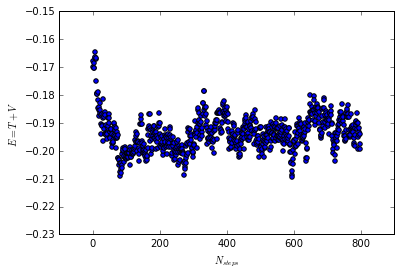

In [85]:
Nparticles, Nsteps, m, walkers, dr = 4, 800, 1, 2000, 0.1
samples, acceptance, E_func = Metroplis_algorithm_walkers(Nparticles, Nsteps, m, walkers, dr)
sample_stack = np.vstack((samples.T[0].ravel(), samples.T[1].ravel())).T

print('Acceptance ratio: {}%'.format(acceptance))
print('Shape of samples: {}'.format(samples.shape))
print('Shape of sample stack: {}'.format(sample_stack.shape))
print('x max/min:', max(sample_stack.T[0]), min(sample_stack.T[0]))
print('y max/min:', max(sample_stack.T[1]), min(sample_stack.T[1]))
plt.scatter([i*m for i in range(int(Nsteps/m))], E_func)
plt.ylabel('$E = T + V$')
plt.xlabel('$N_{steps}$')

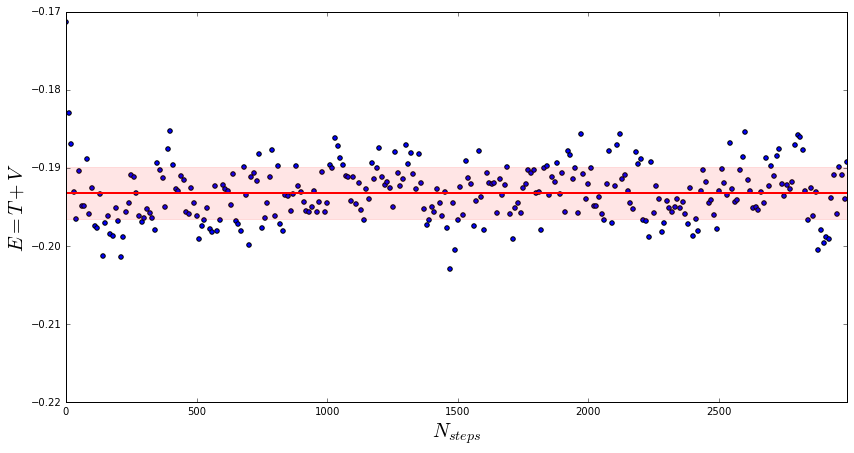

Average E = -0.193175871883 +/- 0.00334136179348


In [92]:
fig = plt.figure(figsize=(14,7))

ax = plt.subplot()

x = [i*m for i in range(int(Nsteps/m))]
ax.scatter(x, E_func)
ax.set_ylabel('$E = T + V$', fontsize=20)
ax.set_xlabel('$N_{steps}$', fontsize=20)
ax.set_xlim(0,max(x))
ax.set_ylim(-0.22, -0.17)

# How many steps for equilibration
N_eq = int(200/m)
E_average = sum(E_func[N_eq:])/len(E_func[N_eq:])

# Calculate the error as the standard deviation
E_error = sum((E_func[N_eq:] - E_average)**2)
E_error = np.sqrt(E_error/len(E_func[N_eq:]))

ax.axhline(y=E_average, color='r', lw=2)
ax.fill_between(x, E_average+E_error, E_average-E_error,
               color='red', alpha=0.1)

plt.show()

print('Average E =', E_average, '+/-', E_error)

This is very similar to the previous wave function. Let's compare them and run longer to see what $\Psi_V$ gives the lowest $E$.

In [87]:
# Input parameters
# will be the same for ech calculation 
Nparticles, Nsteps, m, walkers, dr = 4, 3000, 10, 5000, 0.1

''' First calculation: '''

# Perform a claculation of the first wave function
# Here psi is a linear combination of 4 identical "single-particle" wave functions
def prob_density(R, N):
    ''' The square of the many body wave function
        Psi_V(R). '''

    # e.g. for N=4:
    # psi_v = psi(r_1) + psi(r_2) + psi(r_3) + psi(r_4)
    psi_v = sum([psi(R[n][0], R[n][1]) for n in range(N)])
    
    # Setting anything outside the box equal to zero
    # This will keep particles inside
    for coordinate in R.ravel():
        if abs(coordinate) > 1:
            psi_v = 0
    
    return np.float64(psi_v**2)

samples, acceptance, E_func = Metroplis_algorithm_walkers(Nparticles, Nsteps, m, walkers, dr)
sample_stack = np.vstack((samples.T[0].ravel(), samples.T[1].ravel())).T

# Store the calculation
input_1 = [Nparticles, Nsteps, m, walkers, dr]
output_1 = [sample_stack, samples, acceptance, E_func]

''' Second calculation: '''

# Perform a claculation of the second wave function
# Here psi is a linear combination of 2 distinct "single-particle" wave functions
def prob_density(R, N):
    ''' The square of the many body wave function
        Psi_V(R). '''

    psi_v = sum([psi_1(R[n][0], R[n][1]) for n in range(int(N/2))]) + \
            sum([psi_2(R[n][0], R[n][1]) for n in range(int(N/2),N)])
    
    # Setting anything outside the box equal to zero
    # This will keep particles inside
    for coordinate in R.ravel():
        if abs(coordinate) > 1:
            psi_v = 0
    
    return np.float64(psi_v**2)


# Run another calculation
samples, acceptance, E_func = Metroplis_algorithm_walkers(Nparticles, Nsteps, m, walkers, dr)
sample_stack = np.vstack((samples.T[0].ravel(), samples.T[1].ravel())).T

# Store the calculation
input_2 = [Nparticles, Nsteps, m, walkers, dr]
output_2 = [sample_stack, samples, acceptance, E_func]

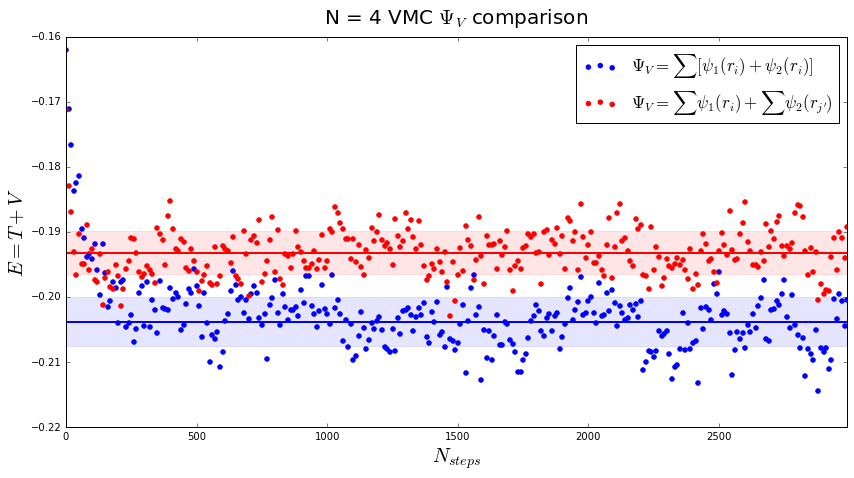

In [90]:
'First calc.'

# Load a calculation
Nparticles, Nsteps, m, walkers, dr = input_1
sample_stack, samples, acceptance, E_func = output_1

# Plot it
fig = plt.figure(figsize=(14,7))
ax = plt.subplot(111)

x = [i*m for i in range(int(Nsteps/m))]
ax.scatter(x, E_func, color='blue', label='$\Psi_V = \sum{[\psi_1(r_i)+\psi_2(r_i)]}$')
ax.set_ylabel('$E = T + V$', fontsize=20)
ax.set_xlabel('$N_{steps}$', fontsize=20)
ax.set_xlim(0,max(x))
ax.set_ylim(-0.31, -0.21)

# How many steps for equilibration
N_eq = int(200/m)
E_average = sum(E_func[N_eq:])/len(E_func[N_eq:])

# Calculate the error as the standard deviation
E_error = sum((E_func[N_eq:] - E_average)**2)
E_error = np.sqrt(E_error/len(E_func[N_eq:]))
ener_1 = [E_average, E_error]

ax.axhline(y=E_average, color='blue', lw=2)
ax.fill_between(x, E_average+E_error, E_average-E_error,
               color='blue', alpha=0.1)


'Second calc.'

# Load a calculation
Nparticles, Nsteps, m, walkers, dr = input_2
sample_stack, samples, acceptance, E_func = output_2

# Plot it
ax = plt.subplot(111)

x = [i*m for i in range(int(Nsteps/m))]
ax.scatter(x, E_func, color='red', label="$\Psi_V = \sum{\psi_1(r_i)} + \sum{\psi_2(r_{j'})}$")

ax.set_xlim(0,max(x))
ax.set_ylim(-0.22, -0.16)

# How many steps for equilibration
N_eq = int(200/m)
E_average = sum(E_func[N_eq:])/len(E_func[N_eq:])
ener_2 = [E_average, E_error]

# Calculate the error as the standard deviation
E_error = sum((E_func[N_eq:] - E_average)**2)
E_error = np.sqrt(E_error/len(E_func[N_eq:]))

ax.axhline(y=E_average, color='red', lw=2)
ax.fill_between(x, E_average+E_error, E_average-E_error,
               color='red', alpha=0.1)

plt.legend(fontsize=17, frameon=True)
plt.title('N = '+str(Nparticles)+' VMC $\Psi_V$ comparison', y=1.02, fontsize=20)

# plt.savefig('figures/VMC_N_4_3k-steps_5k-walkers_Psi_V_compare.png', bbox_inches='tight', dpi=144)

The blue points are for the first wave function $\Psi_V = \sum{(\psi_1(r_i)+\psi_1(r_i))}$. The orange points are for the second wave function $\Psi_V = \sum{\psi_1(r_i)} + \sum{\psi_2(r_{j'})}$

In [91]:
print('Blue calculation')
print('Input parameters:', input_1)
print('Output shapes:', [np.array(x).shape for x in output_1])
print('Ener:', ener_1)
print('')
print('Orange calculation')
print('Input parameters:', input_2)
print('Output shapes:', [np.array(x).shape for x in output_2])
print('Ener:', ener_2)

Blue calculation
Input parameters: [4, 3000, 10, 5000, 0.1]
Output shapes: [(6000000, 2), (1500000, 4, 2), (), (300,)]
Ener: [-0.20376729557384585, 0.0037334919650896174]

Orange calculation
Input parameters: [4, 3000, 10, 5000, 0.1]
Output shapes: [(6000000, 2), (1500000, 4, 2), (), (300,)]
Ener: [-0.19317587188307306, 0.0037334919650896174]
